# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science: 


## Final Project: Predicting Inflammatory Bowel Disease from Human Microbiome Data 


**Harvard University**<br/>
**Fall 2019**<br/>
**Submitted by**: Group 54 - Ilia Gelfat, Mei (May) Xue, Tobie Lee, Cheuk (Alan) Leung<br/>


<hr style="height:2pt">



# Imports and Initialization

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import re
import os

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.cluster import KMeans

# Requires intallation of pyclustering
from pyclustering.cluster import kmeans
from pyclustering.cluster import kmedoids

import warnings
warnings.filterwarnings('ignore')

In [19]:
np.random.seed(500)
tf.random.set_seed(25)

In [0]:
# # Required for using Google Colab
# from google.colab import files, drive

In [0]:
# # Mount your Google Drive, to allow this Colab notebook access to the files on the drive
# # Make sure that you have added the "Microbiome" folder to your own drive, otherwise this will not work!
# # This can be done by right-click on the shared folder -> "Add to drive"
# drive.mount('/content/gdrive')
# root_path = 'gdrive/My Drive/Microbiome'
# os.chdir(root_path)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# Loading and Processing the Data

## Parsing bacterial abundance data

In [0]:
# Load the taxonomic profile data
# 2018 dataset
ibd_2018 = pd.read_csv('IBD/taxonomic_profiles_2018.tsv', sep='\t')

# 2015 (pilot) dataset
ibd_2015 = pd.read_csv('IBD/taxonomic_profiles_2015.tsv', sep='\t')
ibd_2015['#OTU ID'] = ibd_2015.index
ibd_2015.rename(columns={'#Clade_name': 'taxonomy'}, inplace=True)

In [0]:
# Add column for each taxonomic rank
ranks = ['Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus']
for r in ranks: 
  ibd_2015[r] = np.nan
  ibd_2018[r] = np.nan

# Parse the 'taxonomy' string into rank information
def parse_taxonomy(df): 
  for i in range(len(df)): 
    tax = re.findall('(?<=^)[A-Za-z0-9]{2,}|(?<=__)[A-Za-z0-9_]+', df.taxonomy.loc[i])
    if len(tax) > 6:
      tax = tax[:6]
    tax.extend([None]*(6 - len(tax)))
    df.loc[i, ranks] = tax
    for j in range(1, len(ranks)): 
      if isinstance(df.loc[i, ranks[j]], type(None)) or isinstance(df.loc[i, ranks[j]], type(np.nan)):
        df.loc[i, ranks[j:]] = df.loc[i, ranks[j-1]] + '_' + str(df.loc[i, '#OTU ID'])
  return df

ibd_2015 = parse_taxonomy(ibd_2015)
ibd_2018 = parse_taxonomy(ibd_2018)

In [0]:
# Join the two datasets
ibd = pd.concat([ibd_2015, ibd_2018], join='outer', sort=False)
ibd = ibd.fillna(0)
display(ibd.head())

,taxonomy,CSM5FZ3N,CSM5FZ3X,CSM5FZ3Z,CSM5FZ46,CSM5FZ4G,CSM5FZ4O,CSM5MCU4,CSM5MCUI,CSM5MCV1,CSM5MCV3,CSM5MCV5,CSM5MCVB,CSM5MCVH,CSM5MCVV,CSM5MCVZ,CSM5MCW8,CSM5YRY7,ESM5GEZ8,ESM5MEBL,ESM5MEDZ,ESM5MEE2,ESM5MEEA,ESM5MEEG,ESM5MEET,HSM5FZBP,HSM5FZBR,HSM5FZBT,HSM5FZBU,HSM5MD4C,HSM5MD4R,HSM5MD5H,HSM5MD7W,HSM5MD86,MSM5FZ8Y,MSM5FZ9N,MSM5FZ9Q,MSM5FZ9S,MSM5FZ9V,MSM5FZ9Z,...,222170,206625,206740,206731,219658,206562,206757,206569,206673,224844,206627,206667,206536,214994,206538,215085,215067,215061,206726,206570,215055,215049,206615,206712,219656,206683,206709,206608,219691,206701,206604,215003,206628,219675,206728,206754,206718,206657,206670,206655
0,k__Bacteria; p__Firmicutes; c__Clostridia; o__...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,140.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,k__Bacteria; p__Firmicutes; c__Clostridia; o__...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,248.0,22.0,0.0,87.0,42.0,0.0,0.0,135.0,29.0,0.0,0.0,0.0,28.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,k__Bacteria; p__Firmicutes; c__Clostridia; o__...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,k__Bacteria; p__Bacteroidetes; c__Bacteroidia;...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,87.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,k__Bacteria; p__Firmicutes; c__Clostridia; o__...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,58.0,0.0,0.0,0.0,29.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In this data, each row correspsonds to a type of bactria, while each column corresponds to a sample from a patient. The last column includes information about the taxonomic classification of the bacteria. To make the data more suitable for our purposes, we will need to group and aggregate the bacteria by the appropriate rank (e.g. phylum, genus, etc.), and transpose the dataframe such that each row corresponds to one patient. 

In [0]:
def entropy(row):
  '''
  Calculate the entropy of a row vector

  Args: 
    row: Pandas row/series, 1D Numpy array or list with numerical entries
  
  Returns: 
    S: the entropy of the row vector (i.e. -sum(p*log(p)))
  '''
  r = np.array(row)
  r_no_zero = np.copy(r)
  r_no_zero[r_no_zero == 0] = 1
  log_r = np.log(r_no_zero)
  S = -np.dot(r, log_r)
  return S

In [0]:
# Aggregate by all available taxonomic ranks (except kingdom)
ibd_dict = dict.fromkeys(ranks[1:])
ibd_presence_dict = dict.fromkeys(ranks[1:])
for r in ranks[1:]:
  ibd_grouped = ibd.groupby(by=r)
  ibd_dict[r] = ibd_grouped.agg('sum')
# Scale such that all taxa add up to 1
  ibd_rank_sums = np.sum(ibd_dict[r], axis=0)
  ibd_rank_scaled = ibd_dict[r] / ibd_rank_sums
  ibd_rank_scaled = pd.DataFrame(ibd_rank_scaled, columns=ibd_dict[r].columns, index=ibd_dict[r].index)
# Transpose dataframe such that taxa are columns and patients/samples are rows
  ibd_dict[r] = ibd_rank_scaled.transpose()
# Make present/abset dataset
  ibd_presence_dict[r] = ibd_dict[r].copy()
  ibd_presence_dict[r][ibd_presence_dict[r] > 0] = 1
# Add a column counting the number of nonzero entries, and column for entropy
  rank_count = ibd_dict[r].astype(bool).sum(axis=1)
  rank_entropy = ibd_dict[r].apply(entropy, axis=1)
  ibd_dict[r]['rank_count'] = rank_count
  ibd_dict[r]['rank_entropy'] = rank_entropy
  ibd_presence_dict[r]['rank_entropy'] = rank_entropy
# Print dataframe
  print(f'{r} (shape = {ibd_dict[r].shape})')
  display(ibd_dict[r].head(3))
  print('\n')

Phylum (shape = (236, 28))


Phylum,Acidobacteria,Actinobacteria,Armatimonadetes,Bacteroidetes,Chlorobi,Chloroflexi,Cyanobacteria,Deinococcus_Thermus,Elusimicrobia,Euryarchaeota,Fibrobacteres,Firmicutes,Fusobacteria,Gemmatimonadetes,Latescibacteria,Lentisphaerae,Nitrospirae,Parcubacteria,Planctomycetes,Proteobacteria,Spirochaetae,Synergistetes,Tectomicrobia,Tenericutes,Verrucomicrobia,WSA2,rank_count,rank_entropy
CSM5FZ3N,0.0,0.0,0.0,0.038873,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.957969,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003158,0.0,0.0,0.0,0.0,0.0,0.0,3,0.185558
CSM5FZ3X,0.0,0.0,0.0,0.009907,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.061065,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.929028,0.0,0.0,0.0,0.0,0.0,0.0,3,0.284835
CSM5FZ3Z,0.0,0.0,0.0,0.086232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.169763,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.744005,0.0,0.0,0.0,0.0,0.0,0.0,3,0.732387




Class (shape = (236, 70))


Class,4C0d,Acidimicrobiia,Acidobacteria,Actinobacteria,Alphaproteobacteria,Anaerolineae,Bacilli,Bacteroidetes_vadinHA17,Bacteroidia,Betaproteobacteria,Blastocatellia,Caldilineae,Candidatus_Falkowbacteria,Candidatus_Nomurabacteria,Chlorobia,Chloroflexia,Chloroplast,Clostridia,Coriobacteriia,Cyanobacteria,Cytophagia,Deinococci,Deltaproteobacteria,Elusimicrobia,Epsilonproteobacteria,Erysipelotrichi,Erysipelotrichia,Fibrobacteria,Flavobacteriia,Fusobacteriia,Gammaproteobacteria,Gemmatimonadetes,Gitt_GS_136,Holophagae,JG30_KF_CM66,KD4_96,Lentisphaeria,MB_A2_108,ML635J_21,Melainabacteria,Methanobacteria,Mollicutes,Negativicutes,Nitrospira,OPB35_soil_group,Oligosphaeria,Opitutae,Planctomycetacia,Proteobacteria_Incertae_Sedis,Solibacteres,Spartobacteria,Sphingobacteriia,Spirochaetes,Subgroup_2,Subgroup_6,Synergistia,TK10,Thermoleophilia,Thermomicrobia,Thermoplasmata,UA11,Verrucomicrobia_Incertae_Sedis,Verrucomicrobiae,Victivallales,WCHA1_57,WCHB1_32,c,uncultured,rank_count,rank_entropy
CSM5FZ3N,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.038873,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.957969,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003158,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,0.185558
CSM5FZ3X,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.009907,0.640811,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.061065,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.288216,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,0.860170
CSM5FZ3Z,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.086232,0.640781,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.169763,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.103224,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,1.031976




Order (shape = (236, 102))


Order,Acidimicrobiales,Acidobacteriales,Actinomycetales,Aeromonadales,Alteromonadales,Anaerolineales,Anaeroplasmatales,Bacillales,Bacteroidales,Bdellovibrionales,Betaproteobacteria_176,Bifidobacteriales,Blastocatellales,Burkholderiales,Caldilineales,Campylobacterales,Cardiobacteriales,Caulobacterales,Cellvibrionales,Chlorobiales,Chloroflexales,Chromatiales,Chthoniobacterales,Clostridiales,Coriobacteriales,Corynebacteriales,Cytophagales,Deinococcales,Desulfovibrionales,Desulfurellales,Desulfuromonadales,Enterobacteriales,Erysipelotrichales,Fibrobacterales,Flavobacteriales,Frankiales,Fusobacteriales,Gaiellales,Gastranaerophilales,Gemmatimonadales,...,Propionibacteriales,Pseudomonadales,Pseudonocardiales,RF32,Rhizobiales,Rhodobacterales,Rhodocyclales,Rhodospirillales,Rickettsiales,Run_SP154,SC_I_84,Selenomonadales,Solibacterales,Solirubrobacterales,Sphingobacteriales,Sphingomonadales,Spirochaetales,Streptomycetales,Streptophyta,Streptosporangiales,Subgroup_10,SubsectionI,SubsectionII,SubsectionIII,SubsectionIV,Synergistales,Thermales,Thermoanaerobacterales,Thermoplasmatales,Turicibacterales,Unknown_Order,Verrucomicrobiales,Victivallaceae,Victivallales,X35,Xanthomonadales,YS2,o,rank_count,rank_entropy
CSM5FZ3N,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.038873,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.957969,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003158,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,0.185558
CSM5FZ3X,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.009907,0.0,0.0,0.0,0.0,0.640811,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.061065,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.288216,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,0.860170
CSM5FZ3Z,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.086232,0.0,0.0,0.0,0.0,0.640781,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.169763,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.103224,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,1.031976




Family (shape = (236, 246))


Family,0319_6A21,1174_901_12,288_2,ABS_19,Acetobacteraceae,Acidaminococcaceae,Acidimicrobiaceae,Acidobacteriaceae_Subgroup_1_,Actinomycetaceae,Aerococcaceae,Aeromonadaceae,Alcaligenaceae,Alicyclobacillaceae,Alteromonadaceae,Anaerolineaceae,Anaeroplasmataceae,Bacillaceae,Bacteriovoracaceae,Bacteroidaceae,Bacteroidales_199,Bacteroidales_210,Bacteroidales_258,Bacteroidales_315,Bacteroidales_340,Bacteroidales_353,Bacteroidales_397,Bacteroidales_442,Bacteroidales_85,Bacteroidales_S24_7_group,Bdellovibrionaceae,Betaproteobacteria_176,Bifidobacteriaceae,Blastocatellaceae_Subgroup_4_,Bogoriellaceae,Bradyrhizobiaceae,Brevibacteriaceae,Brucellaceae,Burkholderiaceae,Burkholderiales_115,Butyricimonas,...,Sanguibacteraceae,Saprospiraceae,Shewanellaceae,Solibacteraceae_Subgroup_3_,Solirubrobacteraceae,Sphingobacteriaceae,Sphingomonadaceae,Spirochaetaceae,Staphylococcaceae,Streptococcaceae,Streptomycetaceae,Streptophyta_5,Streptosporangiales_Incertae_Sedis,Succinivibrionaceae,Synergistaceae,Thermaceae,Thermoanaerobacteraceae,Thermoplasmatales_Incertae_Sedis,Turicibacteraceae,Unknown_Family,Veillonellaceae,Verrucomicrobiaceae,Victivallaceae,Victivallaceae_160,Victivallaceae_316,Victivallaceae_481,Xanthobacteraceae,Xanthomonadaceae,Xanthomonadales_Incertae_Sedis,YRC22,YS2_155,YS2_205,YS2_243,env_OPS_17,f,mle1_27,uncultured,vadinBE97,rank_count,rank_entropy
CSM5FZ3N,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.038873,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9,1.259378
CSM5FZ3X,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.640811,0.0,0.0,0.0,0.0,0.0,0.0,0.009907,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10,0.926286
CSM5FZ3Z,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.640781,0.0,0.0,0.0,0.0,0.0,0.0,0.086232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,1.065466




Genus (shape = (236, 676))


Genus,Abiotrophia,Acetanaerobacterium,Acetobacterium,Acidaminococcus,Acidisphaera,Acidovorax,Acinetobacter,Actinobacillus,Actinomyces,Actinomycetospora,Actinotignum,Adhaeribacter,Adlercreutzia,Aerococcus,Aeromonas,Aggregatibacter,Akkermansia,Alicyclobacillus,Alishewanella,Alistipes,Allisonella,Allobaculum,Alloiococcus,Alloprevotella,Alloscardovia,Altererythrobacter,Anaerococcus,Anaerofilum,Anaerofustis,Anaeroglobus,Anaeroplasma,Anaerostipes,Anaerotruncus,Angustibacter,Aquamicrobium,Arcobacter,Arcticibacter,Aridibacter,Arthrobacter,Asticcacaulis,...,Uliginosibacterium,Vagococcus,Varibaculum,Variibacter,Veillonella,Veillonellaceae_491,Victivallaceae_160,Victivallaceae_316,Victivallaceae_481,Victivallis,Vogesella,Vulcaniibacterium,Weissella,YRC22_309,YS2_155,YS2_205,YS2_243,Z20,Zimmermannella,Zymomonas,_Clostridium_innocuum_group,_Eubacterium_brachy_group,_Eubacterium_coprostanoligenes_group,_Eubacterium_eligens_group,_Eubacterium_hallii_group,_Eubacterium_nodatum_group,_Eubacterium_rectale_group,_Eubacterium_ventriosum_group,_Eubacterium_xylanophilum_group,_Eubacterium_yurii_group,_Ruminococcus_gauvreauii_group,_Ruminococcus_gnavus_group,_Ruminococcus_torques_group,dolichum,g,gnavus,torques,uncultured,rank_count,rank_entropy
CSM5FZ3N,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.007289,0.0,0.0,25,1.945823
CSM5FZ3X,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,15,0.937865
CSM5FZ3Z,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,6,1.071117


## Processing patient metadata

In [0]:
# Load patient metadata
md = pd.read_csv('IBD/hmp2_metadata.csv', low_memory=False)

# Drop irrelevant columns
md = md.drop(columns=['Project', 'site_sub_coll', 'Research Project', 
                      'interval_days', 'IntervalName', 'IntervalSequence', 
                      'ProjectSpecificID', 'PDO Number', 'GSSR IDs', 'Product', 'LCSET', 'WR ID', 
                      'Aggregated Lanes', '# Lanes in Aggregation', 
                      'reads_raw', 'reads_filtered', 'reads_qc_fail', 
                      'reads_human', 'reads_ribosomal', 'reads_viral', 'Delta',
                      'Whole blood received at Broad:', 
                      'Serum tube #1 received at CSMC:', 
                      'Serum tubes #2-4 received at MGH:', 
                      'Number of flora tubes collected:', 
                      'Rectum Flora:', 'Have samples been sent for histopathology?',
                      'FLora received at MGH:', 'RNA/DNA received at Broad:', 
                      'ECP received at Washington U:', 
                      'Number of DNA/RNA tubes collected:', 'Rectum DNA/RNA:', 
                      'Did the patient sign informed consent?', 
                      'Did the subject withdraw from the study?', 
                      'Was subject terminated by investigator?', 
                      'Partial Endoscopy', 'Partial Endoscopy.1', 
                      'Viromics received at Baylor:', 'FecalCal received at MGH:', 
                      'Proteomics received at LBNL:', 'Tube A and B received at Broad:', 
                      'Has the next visit been scheduled?', 
                      'Has the subject been given new stool kits?', 
                      'Has the subject completed the FFQ/YAQ?', 
                      'Scanned FFQ/YAQ document:', 
                      'FFQ/YAQ results:', 'Were study bloods drawn?', 
                      'Whole Blood (DNA)', 'Serum #1', 'Serum #2', 'Serum #3', 'Serum #4',
                      'Ileum flora:', 'Other inflamed flora:', 'Non-inflamed flora:',
                      'Number of tubes collected for epithelial cell biopsies:',
                      'Rectum cell biopsy:', 'Ileum cell biopsy:', 
                      'Other inflamed cell biopsy:', 'Other non-inflamed cell biopsy:', 
                      'Ileum DNA/RNA:', 'Non-inflamed DNA/RNA:', 'Other Inflamed DNA/RNA:', 
                      'Was stool sample collected?', 'Tube A: DNA/RNA', 'hbi', 
                      'Tube A: Metabolomics', 'Tube A: Storage', 'Tube A:Viromics', 
                      'Tube B:Fecal Calprotectin', 'fecalcal', 'Tube B:Proteomics', 
                      'Sample ID: Tube B (No preservative)', 'Was HBI completed?', 
                      'Stool Sample ID:  Tube A  (EtOH)', 'stool_id', 'fecalcal_ng_ml', 
                      'Was SCCAI completed?', 'sccai', 'SES-CD Score', 'SIBDQ Score'], axis=1)

# Fill NaN values for each patient
md_grouped = md.groupby(by=['Participant ID'])
md_filled = md_grouped.apply(lambda x: x.fillna(x.mode(dropna=True).iloc[0], inplace=False))
md_filled = md_filled.droplevel(0)
md_filled = md_filled.sort_index()

In [0]:
# Select relevant subset of data
md_16S = md_filled.loc[md_filled['data_type'].isin(['biopsy_16S', 'stool_16S'])]
md_relevant = md_16S.loc[md_16S['External ID'].isin(ibd_dict[ranks[1]].index)]

# Convert 'diagnosis' to numeric
# 0: CD, 1: UC, 2: nonIBD
labels = ['CD', 'UC', 'nonIBD']
diagnosis_val = md_relevant['diagnosis'].copy()
for i in range(len(labels)):
  diagnosis_val.loc[diagnosis_val == labels[i]] = i
md_numeric_diagnosis = md_relevant.copy()
md_numeric_diagnosis['diagnosis'] = diagnosis_val

In [0]:
# Merge bacterial data with diagnosis
diagnosis = md_numeric_diagnosis[['External ID', 'diagnosis']]

for r in ranks[1:]:
  merged = pd.merge(ibd_dict[r], diagnosis, how='left', left_index=True, right_on='External ID')
  merged.set_index('External ID', inplace=True)
  merged.to_csv('IBD/' + r + '_only.csv', sep='\t')
  merged = pd.merge(ibd_presence_dict[r], diagnosis, how='left', left_index=True, right_on='External ID')
  merged.set_index('External ID', inplace=True)
  merged.to_csv('IBD/' + r + '_presence_only.csv', sep='\t')

In [0]:
# Fill/impute NaN values
md_numeric_diagnosis['Education Level'] = md_numeric_diagnosis['Education Level'].fillna('Unknown/Not Reported')
median_fill_cols = ['consent_age', 'Height', 'BMI', 'Weight.1']
for col in median_fill_cols:
  md_numeric_diagnosis[col] = md_numeric_diagnosis[['sex', col]].groupby('sex').transform(lambda x: x.fillna(x.median()))
md_numeric_diagnosis.replace('Not sure', 'Not Sure', inplace=True)
not_sure_cols = ['Were you exposed to cigarette smoke as a child?', 
                 'Do you use non-steroidal anti-inflammatory medications', 
                 'In the past 3 months, have you consumed any probiotics (other than yogurt)']
for col in md_numeric_diagnosis: 
  if 'Not Sure' in md_numeric_diagnosis[col].values: 
    not_sure_cols.append(col)
md_numeric_diagnosis[not_sure_cols] = md_numeric_diagnosis[not_sure_cols].fillna('Not Sure')
mode_fill_cols = ['Did you grow up on a farm?', 
                  'Lomotil', 'Flagyl (Metronidazole)', 'Cipro (Ciprofloxin)', 
                  'Xifaxin (rifaxamin)', 'Other Antibiotic:', 
                  'Prednisone', 'IV steroids', 
                  'Azathioprine (Imuran, Azasan)', 'Methotrexate', 
                  'Mercaptopurine (Purinethol, 6MP)', 'FOS']
md_numeric_diagnosis[mode_fill_cols] = md_numeric_diagnosis[mode_fill_cols].fillna(md_numeric_diagnosis[mode_fill_cols].mode().iloc[0])

In [0]:
# Drop additional irrelevant/sparse/redundant columns
# This includes removing obvious correlates of disease (e.g. Crohn's-specific drugs), 
# the usage of which implies you have already been diagnosed, making not useful for modeling
df = md_numeric_diagnosis.copy()
df = df.drop(['Participant ID', 'week_num', 'date_of_receipt', 'visit_num', 
              'Age at diagnosis', 'biopsy_location', 'is_inflamed', 
              'Have the following labs been drawn within +/- 2 weeks?', 
              'Arthralgias', 'Dipentum (olsalazine)', 
              'Rowasa enemas (mesalamine enemas)', 
              'Canasa suppositories (mesalamine suppositories)', 
              'Entocort (Budesonide)', 'VSL #3', 'Remicade (Infliximab)', 
              'Humira (Adalimumab)', 'Cimzia (Certlizumab)', 'Asacol (mesalamine)', 
              'Pentasa (mesalamine)', 'Lialda (mesalamine)', 
              'Colozal (balasalizide)', 'Sulfasalizine (Azulfidine)', 
              'Has the subject undergone any relevant GI imaging procedures (abdomen, pelvis et', 
              'Has the subject been given the C1 kit and asked to collect and submit a sample', 
              'Weight'], axis=1)

# Drop columns with more than 40 missing values and/or only single value
df = df.dropna(thresh=len(df)-40, axis=1)
df = df.drop(columns=df.columns[df.nunique() < 2])

In [0]:
# Replace text-based predictors with numerical values
df.replace(['No', 'Not Sure', 'Yes'], [0, 0.5, 1], inplace=True)
df.replace(['No, I did not consume these products in the last 7 days', 
            'Within the past 4 to 7 days', 
            'Within the past 2 to 3 days', 
            'Yesterday, 1 to 2 times', 
            'Yesterday, 3 or more times'], 
           [0, 1, 2, 3, 4], inplace=True)
df.replace(['biopsy_16S', 'stool_16S'], [0, 1], inplace=True)
df.replace(['MGH', 'MGH Pediatrics', 'Cedars-Sinai', 'Cincinnati', 'Emory'], 
           [0, 1, 2, 3, 4], inplace=True)
df.replace(['Unknown/Not Reported', 
            '7th grade or less', 
            'Some high school', 
            'High school graduate or GED', 
            'Some college, no degree', 
            "Bachelor's degree", 
            "Master's degree", 
            'Professional/Doctoral degree'], 
           [0, 1, 2, 3, 4, 5, 6, 7], inplace=True)
df.replace(['Unknown/Not Reported', 
            'Unpaid/volunteer', 
            'Student', 
            'Paid', 
            'Retired'], 
           [0, 1, 2, 3, 4], inplace=True)
df.replace(['Not Hispanic or Latino', 'Hispanic or Latino'], [0, 1], inplace=True)
df.replace(['Never taken', 
            'Taken prior to baseline', 
            'Taken since last visit', 
            'Current'], 
           [0, 1, 2, 3], inplace=True)
df.replace(['White', 
            'Other', 
            'More than one race', 
            'Black or African American', 
            'American Indian or Alaska Native'], 
           [0, 1, 2, 3, 4], inplace=True)
df.replace(['Female', 'Male'], [0, 1], inplace=True)

In [0]:
# Change column names to be more brief, consistent and/or descriptive
col_names = {'data_type': 'stool', 'site_name': 'site', 
             'Education Level': 'education', 'Occupation': 'occupation', 
             'consent_age': 'age', 
             'Soft drinks, tea or coffee with sugar (corn syrup, maple syrup, cane sugar, etc)': 'food_soft_drinks', 
             'Diet soft drinks, tea or coffee with sugar (Stevia, Equal, Splenda etc)': 'food_diet_drinks', 
             'Fruit juice (orange, apple, cranberry, prune etc.)': 'food_fruit_juice', 
             'Water': 'food_water', 'Alcohol (beer, brandy, spirits, hard liquor, wine, aperitif, etc.)': 'food_alcohol', 
             'Yogurt or other foods containing active bacterial cultures (kefir, sauerkraut)': 'food_fermented', 
             'Dairy (milk, cream, ice cream, cheese, cream cheese)': 'food_dairy', 
             'Probiotic': 'food_probiotic', 
             'Fruits (no juice) (Apples, raisins, bananas, oranges, strawberries, blueberries': 'food_fruit', 
             'Vegetables (salad, tomatoes, onions, greens, carrots, peppers, green beans, etc)': 'food_vegetables', 
             'Beans (tofu, soy, soy burgers, lentils, Mexican beans, lima beans etc)': 'food_beans', 
             'Whole grains (wheat, oats, brown rice, rye, quinoa, wheat bread, wheat pasta)': 'food_whole_grains', 
             'Starch (white rice, bread, pizza, potatoes, yams, cereals, pancakes, etc.)': 'food_starch', 
             'Eggs': 'food_eggs', 
             'Processed meat (other red or white meat such as lunch meat, ham, salami, bologna': 'food_processed_meat', 
             'Red meat (beef, hamburger, pork, lamb)': 'food_red_meat', 
             'White meat (chicken, turkey, etc.)': 'food_white_meat', 
             'Shellfish (shrimp, lobster, scallops, etc.)': 'food_shellfish', 
             'Fish (fish nuggets, breaded fish, fish cakes, salmon, tuna, etc.)': 'food_fish', 
             'Sweets (pies, jam, chocolate, cake, cookies, etc.)': 'food_sweets',
             'Tea or coffee no sugar and no sugar replacement': 'food_tea_coffee', 
             '1) In the past 2 weeks, have you received any of the following medications': 'drugs_2week_medication', 
             'Antibiotics': 'drugs_2week_antibiotics', 'Chemotherapy': 'drugs_2week_chemotherapy', 
             'Immunosuppressants (e.g. oral corticosteroids)': 'drugs_2week_immunosuppressants', 
             '2) In the past 2 weeks, have you undergone a colonoscopy or other procedure': 'procedure_2week_colonoscopy', 
             '3) In the past 2 weeks, have you used an oral contrast': 'procedure_2week_contrast_agent', 
             '4) In the past 2 weeks, have you had diarrhea?': 'condition_2week_diarrhea', 
             '5) In the past 2 weeks, have you been hospitalized?': 'procedure_2week_hospitalized', 
             '6) Have you ever had bowel surgery?': 'procedure_2week_bowel_surgery', 
             'Did you grow up on a farm?': 'childhood_farm', 
             'Did you attend daycare as a child?': 'childhood_daycare', 
             'Were you exposed to cigarette smoke as a child?': 'childhood_cigarettes', 
             'Were you born prematurely (more than 3 weeks early)?': 'childhood_premature', 
             'Were you born in a hospital?': 'childhood_hospital_birth',
             'Were you born via C-section?': 'childhood_c_section',
             'Were you breastfed as an infant?': 'childhood_breastfed', 
             'Were you treated with antibiotics before the age of one?': 'childhood_antibiotics',
             'Were you hospitalized before the age of five?': 'childhood_hospitalized', 
             'Did you have pets growing up?': 'childhood_pets',   
             'In the past 2 months, have you used any acid reducing medication': 'drugs_2month_acid', 
             'In the past 2 months, have you used any medications modifying bile production': 'drugs_2month_bile', 
             'Do you use non-steroidal anti-inflammatory medications': 'drugs_nsaid', 
             'In the past 6 months, have you used antibiotics?': 'drugs_6month_antibiotics', 
             'In the past 3 months, have you consumed any probiotics (other than yogurt)': 'drugs_3month_probiotics', 
             'Aphthous ulcers': 'condition_aphthous_ulcers', 
             'Abscess': 'condition_abcess', 'Arthralgia': 'condition_arthralgia', 
             'Hispanic or Latino Origin': 'hispanic', 'BMI': 'bmi', 
             'Height': 'height', 'Weight.1': 'weight', 
             'Flagyl (Metronidazole)': 'drugs_flagyl', 'Cipro (Ciprofloxin)': 'drugs_cipro', 
             'Xifaxin (rifaxamin)': 'drugs_xifaxin', 'Other Antibiotic:': 'drugs_other_antibiotics', 
             'Prednisone': 'drugs_prednisone', 'IV steroids': 'drugs_iv_steroids', 
             'Azathioprine (Imuran, Azasan)': 'drugs_azathioprine', 
             'Methotrexate': 'drugs_methotrexate', 
             'Mercaptopurine (Purinethol, 6MP)': 'drugs_mercaptopurine', 'FOS': 'drugs_fos'}
df.rename(columns=col_names, inplace=True)
df.set_index('External ID', inplace=True)

In [0]:
# Convert to one-hot encoding
cat_cols = df.columns[df.nunique() > 2]
cat_cols = cat_cols.drop(['diagnosis', 'age', 'height', 'weight', 'bmi'])
df_onehot = pd.get_dummies(df, columns=cat_cols, drop_first=True)

In [0]:
# Save the processed dataframe to file
df.to_csv('IBD/metadata_numeric.csv', sep='\t')
df_onehot.to_csv('IBD/metadata_onehot.csv', sep='\t')

In [0]:
# Merge metadata and bacterial abundance data, and save to file
for r in ranks[1:]:
  merged_num = pd.merge(ibd_dict[r], df, how='left', left_index=True, right_index=True)
  merged_num.index.name = 'External ID'
  merged_num.to_csv('IBD/' + r + '_metadata_numeric.csv', sep='\t')

  merged_num = pd.merge(ibd_presence_dict[r], df, how='left', left_index=True, right_index=True)
  merged_num.index.name = 'External ID'
  merged_num.to_csv('IBD/' + r + '_presence_metadata_numeric.csv', sep='\t')

  merged_onehot = pd.merge(ibd_dict[r], df_onehot, how='left', left_index=True, right_index=True)
  merged_onehot.index.name = 'External ID'
  merged_onehot.to_csv('IBD/' + r + '_metadata_onehot.csv', sep='\t')

  merged_onehot = pd.merge(ibd_presence_dict[r], df_onehot, how='left', left_index=True, right_index=True)
  merged_onehot.index.name = 'External ID'
  merged_onehot.to_csv('IBD/' + r + '_presence_metadata_onehot.csv', sep='\t')

# Exploratory Data Analysis

## Summary statistics

In [20]:
# Load dataframe from file
df = pd.read_csv('IBD/Phylum_metadata_numeric.csv', sep='\t', index_col='External ID')

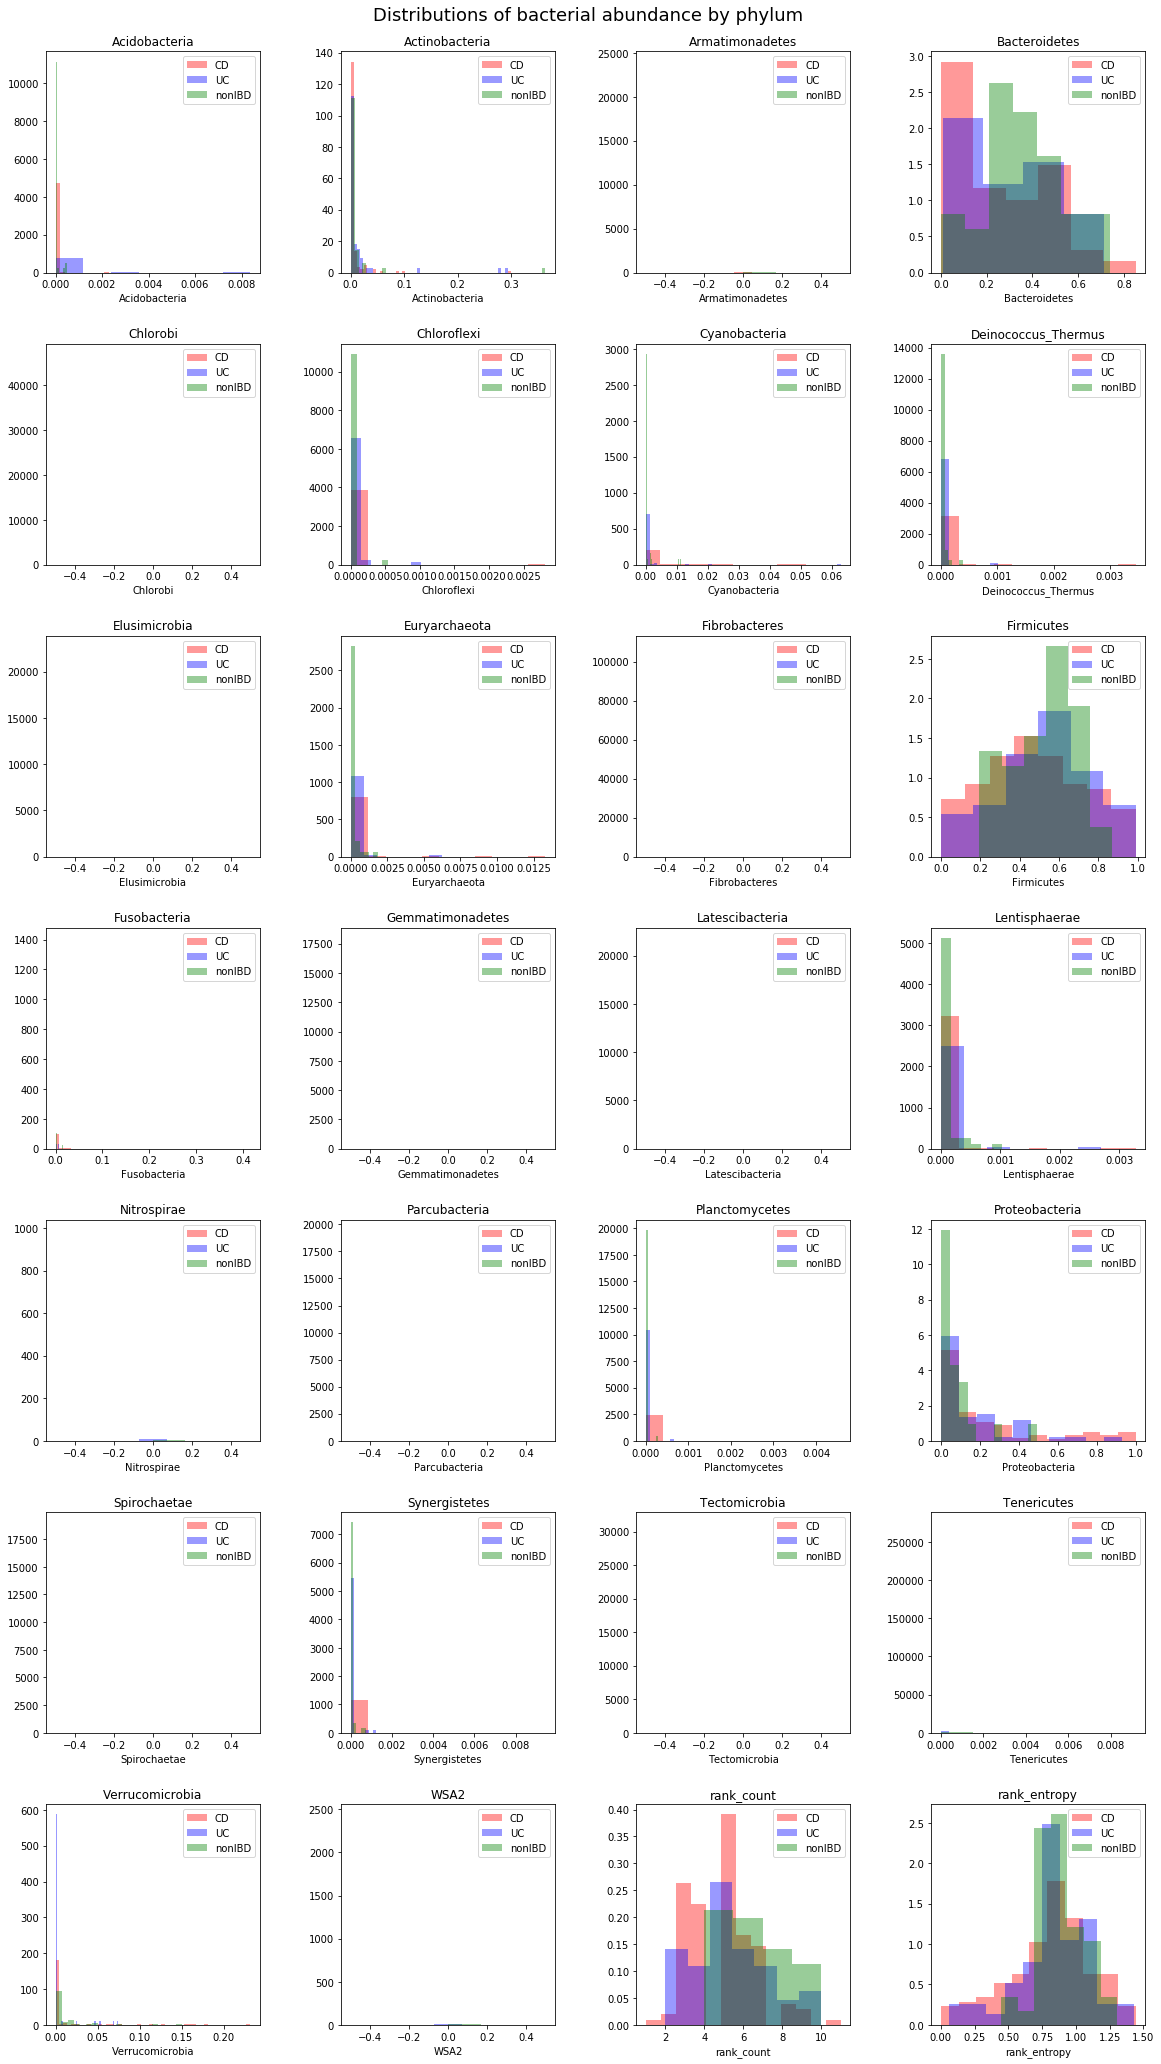

In [59]:
# Plot distribution of bacterial abundance by phylum for each diagnosis
labels = ['CD', 'UC', 'nonIBD']
color_dict = {'nonIBD': 'g', 'UC': 'b', 'CD': 'r'}
n_phyla = 28

fig, axs = plt.subplots(7, 4, figsize=(16, 28))
main_title = fig.suptitle('Distributions of bacterial abundance by phylum', fontsize=18)
main_title.set_y(1.015)
plt.gcf().tight_layout(h_pad=5, w_pad=5)
axs_list = axs.ravel()

for i in range(n_phyla):
  fig = plt.subplot(7, 4, i+1)
  ax = axs_list[i]
  feature = df.columns[i]
  for j in range(len(labels)): 
    ax = sns.distplot(df[feature].loc[df['diagnosis'] == j], 
                      hist=True, kde=False, norm_hist=True, 
                      color=color_dict[labels[j]], label=labels[j])
  plt.legend()
  plt.title(feature)

plt.show()

In [60]:
# Count number of patient within each diagnosis category
display(df['diagnosis'].value_counts())

0    133
1     56
2     47
Name: diagnosis, dtype: int64

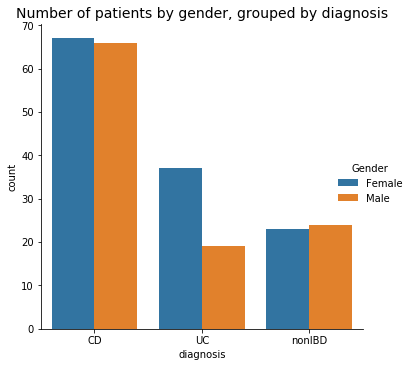

In [65]:
# Number of patients by gender, grouped by diagnosis
g = sns.catplot(x='diagnosis', hue='sex', kind='count', data=df, order=[0, 1, 2], legend=True, legend_out=True)
g.set_xticklabels(['CD', 'UC', 'nonIBD'])
plt.title('Number of patients by gender, grouped by diagnosis', fontsize=14)
new_title = 'Gender'
g._legend.set_title(new_title)
new_labels = ['Female', 'Male']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)
plt.show()

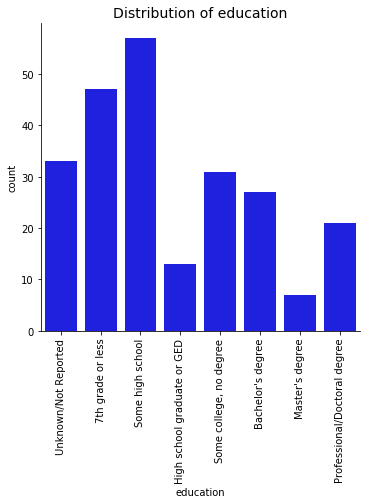

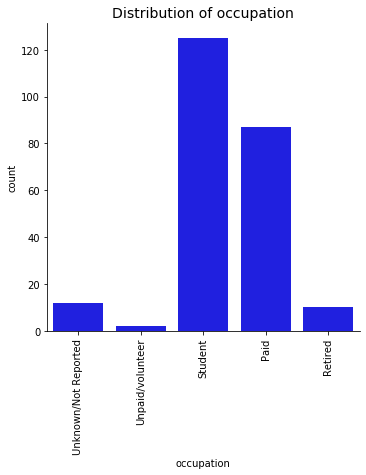

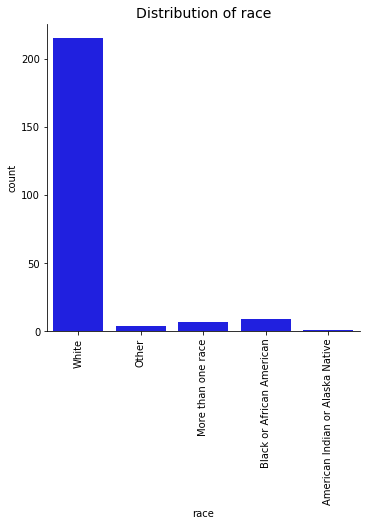

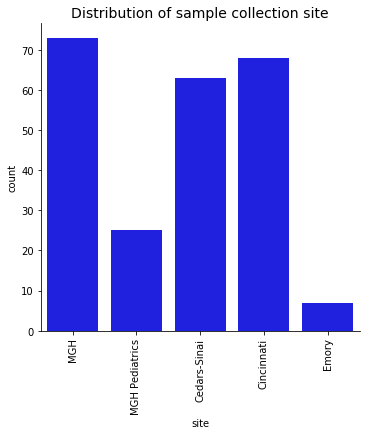

In [67]:
# Distribution of additional categorical predictors
# Education
g = sns.catplot(x='education', kind='count', data=df, color='b')
g.set_xticklabels(['Unknown/Not Reported', 
                   '7th grade or less', 
                   'Some high school', 
                   'High school graduate or GED', 
                   'Some college, no degree', 
                   "Bachelor's degree", 
                   "Master's degree", 
                   'Professional/Doctoral degree'], rotation=90)
g.ax.set_title(f'Distribution of education', fontsize=14)
plt.show()

# Occupation
g = sns.catplot(x='occupation', kind='count', data=df, color='b')
g.set_xticklabels(['Unknown/Not Reported', 
                   'Unpaid/volunteer', 
                   'Student', 
                   'Paid', 
                   'Retired'], rotation=90)
g.ax.set_title(f'Distribution of occupation', fontsize=14)
plt.show()

# Race
g = sns.catplot(x='race', kind='count', data=df, color='b')
g.set_xticklabels(['White', 
                   'Other', 
                   'More than one race', 
                   'Black or African American', 
                   'American Indian or Alaska Native'], rotation=90)
g.ax.set_title(f'Distribution of race', fontsize=14)
plt.show()

# Site
g = sns.catplot(x='site', kind='count', data=df, color='b')
g.set_xticklabels(['MGH', 
                   'MGH Pediatrics', 
                   'Cedars-Sinai', 
                   'Cincinnati', 
                   'Emory'], rotation=90)
g.ax.set_title(f'Distribution of sample collection site', fontsize=14)
plt.show()

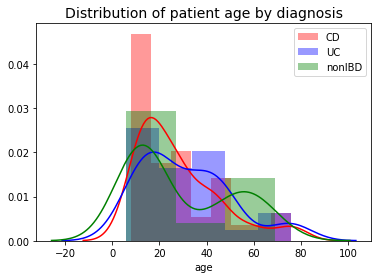

In [0]:
# Distribution of age
labels = ['CD', 'UC', 'nonIBD']
color_dict = {'nonIBD': 'g', 'UC': 'b', 'CD': 'r'}
for j in range(len(labels)): 
  ax = sns.distplot(df['age'].loc[df['diagnosis'] == j], 
                    hist=True, kde=True, norm_hist=True, 
                    color=color_dict[labels[j]], label=labels[j])
plt.title('Distribution of patient age by diagnosis', fontsize=14)
plt.legend()
plt.show()

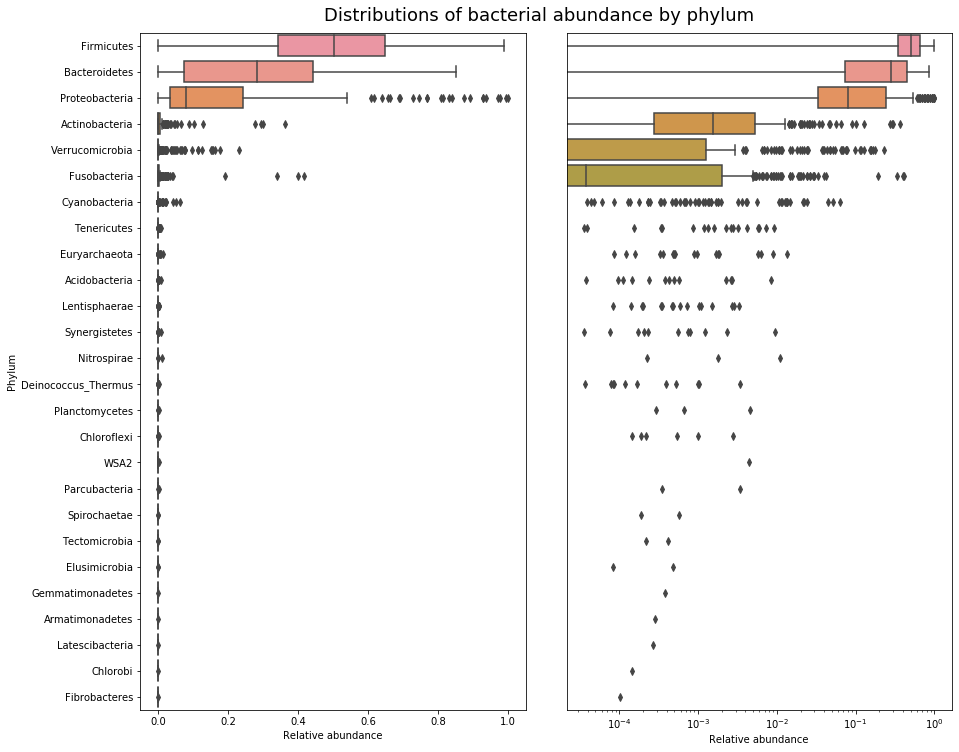

In [22]:
# Distribution of bacterial abundance by phylum
n_phyla = 26

means = df[df.columns[:n_phyla]].mean()
sorted_cols = df.columns[np.argsort(means)[::-1]]

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 10))
main_title = fig.suptitle('Distributions of bacterial abundance by phylum', fontsize=18)
main_title.set_y(1.015)
plt.gcf().tight_layout(h_pad=5, w_pad=1)

# Linear scale
axs[0] = plt.subplot(1, 2, 1)
sns.boxplot(data=df[df.columns[:n_phyla]], ax=axs[0], orient='h', order=sorted_cols)
axs[0].set_ylabel('Phylum')
axs[0].set_xlabel('Relative abundance')
# axs[0].set_title('Distribution of bacterial abundance by phylum', fontsize=14)

# Log scale
axs[1] = plt.subplot(1, 2, 2)
sns.boxplot(data=df[df.columns[:n_phyla]], ax=axs[1], orient='h', order=sorted_cols)
axs[1].get_yaxis().set_ticks([])
axs[1].set_xlabel('Relative abundance')
axs[1].set_xscale('log')

plt.show()

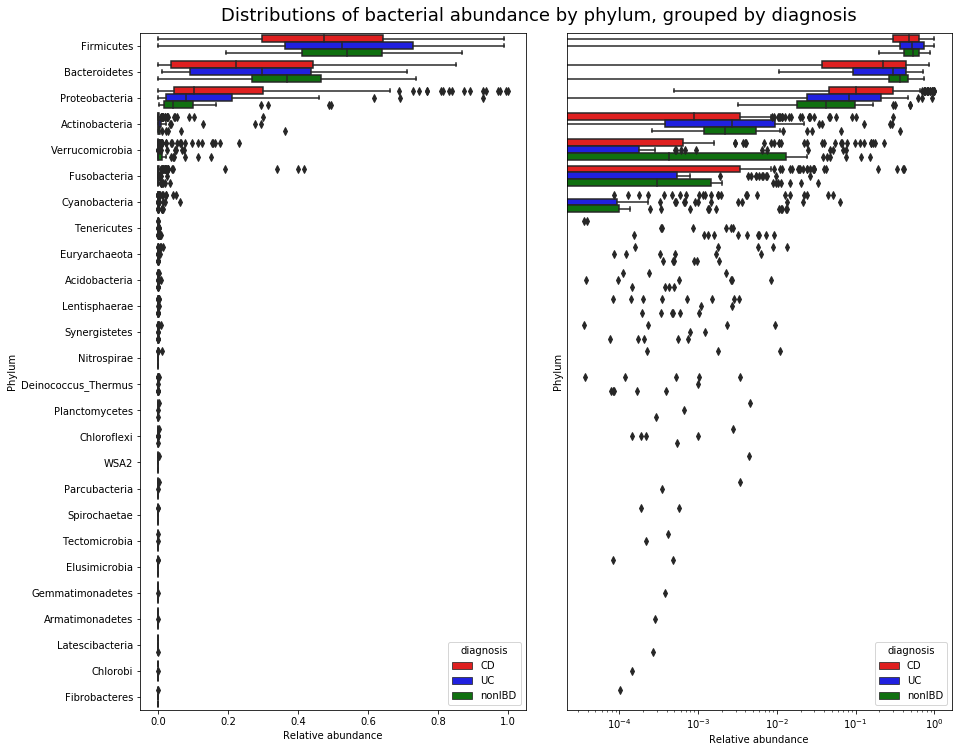

In [45]:
# Load dataframe from file
df = pd.read_csv('IBD/Phylum_only.csv', sep='\t', index_col='External ID')
df = df.drop(['rank_count', 'rank_entropy'], axis=1)
df_long = pd.melt(df, 'diagnosis', var_name='Phylum', value_name='Relative abundance')
df_long['diagnosis'] = df_long['diagnosis'].replace([0, 1, 2], ['CD', 'UC', 'nonIBD'])
my_pal = {'CD': 'r', 'UC': 'b', 'nonIBD': 'g'}
# plt.figure(figsize=(6, 15))
# sns.boxplot(data=df_long, y='Phylum', hue='diagnosis', x='Relative abundance', orient='h', order=sorted_cols)
# plt.title('Distribution of bacterial abundance by phylum, grouped by diagnosis', fontsize=18)
# plt.show()

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 10))
main_title = fig.suptitle('Distributions of bacterial abundance by phylum, grouped by diagnosis', fontsize=18)
main_title.set_y(1.015)
plt.gcf().tight_layout(h_pad=5, w_pad=1)

# Linear scale
axs[0] = plt.subplot(1, 2, 1)
sns.boxplot(data=df_long, y='Phylum', hue='diagnosis', x='Relative abundance', orient='h', order=sorted_cols, 
            palette=my_pal, ax=axs[0])

# Log scale
axs[1] = plt.subplot(1, 2, 2)
sns.boxplot(data=df_long, y='Phylum', hue='diagnosis', x='Relative abundance', orient='h', order=sorted_cols, 
            palette=my_pal, ax=axs[1])
axs[1].get_yaxis().set_ticks([])
axs[1].set_xscale('log')

plt.show()

## Principal component analysis (PCA)

In [87]:
# Perform principal component analysis on bacterial abundance
df_pca = pd.read_csv('IBD/Phylum_only.csv', sep='\t', index_col='External ID')
bact_X = np.array(df_pca.drop('diagnosis', axis=1, inplace=False))

PCA_scaler = StandardScaler().fit(bact_X)
bact_scaled = PCA_scaler.transform(bact_X)

bact_pca = PCA().fit(bact_scaled)
bact_transformed = bact_pca.transform(bact_scaled)

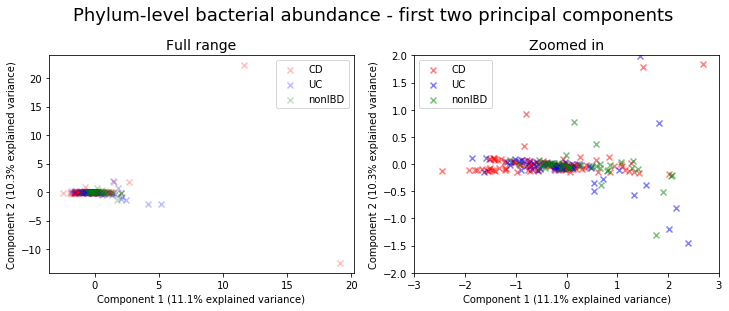

In [88]:
# Plot first two components
component_1 = bact_transformed.transpose()[0]
component_2 = bact_transformed.transpose()[1]
ex_var = bact_pca.explained_variance_ratio_
labels = ['CD', 'UC', 'nonIBD']
color_dict = {'nonIBD': 'g', 'UC': 'b', 'CD': 'r'}

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
main_title = fig.suptitle('Phylum-level bacterial abundance - first two principal components', fontsize=18)
main_title.set_y(1.05)

axs[0] = plt.subplot(1, 2, 1)
for i in range(len(labels)): 
  index = df_pca['diagnosis'] == i
  axs[0].scatter(component_1[index], component_2[index], label=labels[i], color=color_dict[labels[i]], alpha=0.25, marker='x')
axs[0].set_title('Full range', fontsize=14)
axs[0].set_xlabel('Component 1 ({:.1f}% explained variance)'.format(100*ex_var[0]))
axs[0].set_ylabel('Component 2 ({:.1f}% explained variance)'.format(100*ex_var[1]))
axs[0].legend()

axs[1] = plt.subplot(1, 2, 2)
for i in range(len(labels)): 
  index = df_pca['diagnosis'] == i
  axs[1].scatter(component_1[index], component_2[index], label=labels[i], color=color_dict[labels[i]], alpha=0.5, marker='x')
axs[1].set_title('Zoomed in', fontsize=14)
axs[1].set_xlabel('Component 1 ({:.1f}% explained variance)'.format(100*ex_var[0]))
axs[1].set_ylabel('Component 2 ({:.1f}% explained variance)'.format(100*ex_var[1]))
axs[1].set_xlim([-3, 3])
axs[1].set_ylim([-2, 2])
axs[1].legend()

plt.show()

Variance explained by PCA component 1: 11.1%
Variance explained by PCA component 2: 10.3%
17 / 28 components are needed to explain 90.0% of variance



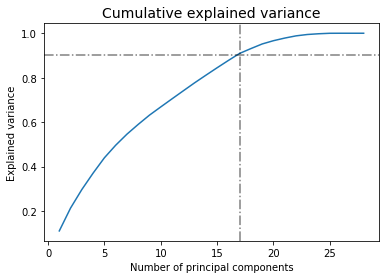

In [89]:
# Calculate and report explained variance
print('Variance explained by PCA component 1: {:.1f}%'.format(100*ex_var[0]))
print('Variance explained by PCA component 2: {:.1f}%'.format(100*ex_var[1]))
cum_ex_var = np.cumsum(ex_var)
ex_var_threshold = 0.9
ex_var_greater_than = np.argwhere(cum_ex_var>ex_var_threshold)
n_90 = ex_var_greater_than[0][0] + 1
print('{} / {} components are needed to explain {:.1f}% of variance\n'.format(n_90, len(ex_var), ex_var_threshold*100))

# Plot cumulative explained variance
plt.plot(range(1, len(cum_ex_var)+1), cum_ex_var)
plt.axvline(x=n_90, linestyle='-.', color='k', alpha=0.5)
plt.axhline(y=0.9, linestyle='-.', color='k', alpha=0.5)
plt.title('Cumulative explained variance', fontsize=14)
plt.xlabel('Number of principal components')
plt.ylabel('Explained variance')
plt.show()

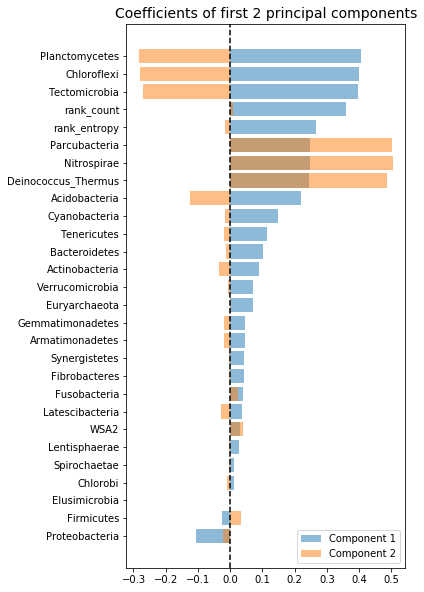

In [90]:
# Plot coefficients for first 2 principal components
predictors = df_pca.columns.drop('diagnosis')
predictor_ind = np.argsort(bact_pca.components_[0])
plt.figure(figsize=(5, 10))
plt.barh(range(len(predictors)), bact_pca.components_[0][predictor_ind], alpha=0.5, label='Component 1')
plt.barh(range(len(predictors)), bact_pca.components_[1][predictor_ind], alpha=0.5, label='Component 2')
plt.axvline(0, color='k', linestyle='--')
plt.yticks(range(len(predictors)), labels=predictors[predictor_ind], rotation=0)
plt.title('Coefficients of first 2 principal components', fontsize=14)
plt.legend()
plt.show()

# Baseline Model - Logistic regression

Try logistic regression using bacterial abundance only: 

In [0]:
# LASSO regularization
logit1_dict = dict.fromkeys(ranks[1:])
print('---\nAccuracy scores of logistic resgression model (LASSO):\n---')
for r in ranks[1:]: 
  # Load dataframe from file
  df_logit = pd.read_csv('IBD/' + r + '_only.csv', sep='\t', index_col='External ID')
  # Split to training and test sets
  X_train, X_test, y_train, y_test = train_test_split(df_logit.loc[:, df_logit.columns != 'diagnosis'], 
                                                      df_logit['diagnosis'], test_size=0.2, 
                                                      random_state = 109, 
                                                      stratify = df_logit['diagnosis'])
  # Standardize the data
  logreg_scaler = StandardScaler().fit(X_train)
  X_train_scaled = logreg_scaler.transform(X_train)
  X_test_scaled = logreg_scaler.transform(X_test)
  # Fit a logistic regression model with Ridge regularization
  logreg1_model = LogisticRegressionCV(multi_class='multinomial', cv=5, Cs=21, penalty='l1', solver='saga', max_iter=10000).fit(X_train_scaled, y_train)
  logit1_dict[r] = logreg1_model
  # Evaluate the model
  y_pred1_train = logreg1_model.predict(X_train_scaled)
  y_pred1_test = logreg1_model.predict(X_test_scaled)
  logreg1_acc_train = accuracy_score(y_train, y_pred1_train)
  logreg1_acc_test = accuracy_score(y_test, y_pred1_test)

  print(f'{r}:')
  print('Training:   {:.3f}'.format(logreg1_acc_train))
  print('Test:       {:.3f}\n'.format(logreg1_acc_test))

---
Accuracy scores of logistic resgression model (LASSO):
---
Phylum:
Training:   0.660
Test:       0.562

Class:
Training:   0.691
Test:       0.562

Order:
Training:   0.840
Test:       0.438

Family:
Training:   0.819
Test:       0.500

Genus:
Training:   0.979
Test:       0.500



In [0]:
# Ridge regularization
logit2_dict = dict.fromkeys(ranks[1:])
print('---\nAccuracy scores of logistic resgression model (Ridge):\n---')
for r in ranks[1:]: 
  # Load dataframe from file
  df_logit = pd.read_csv('IBD/' + r + '_only.csv', sep='\t', index_col='External ID')
  # Split to training and test sets
  X_train, X_test, y_train, y_test = train_test_split(df_logit.loc[:, df_logit.columns != 'diagnosis'], 
                                                      df_logit['diagnosis'], test_size=0.2, 
                                                      random_state = 109, 
                                                      stratify = df_logit['diagnosis'])
  # Standardize the data
  logreg_scaler = StandardScaler().fit(X_train)
  X_train_scaled = logreg_scaler.transform(X_train)
  X_test_scaled = logreg_scaler.transform(X_test)
  # Fit a logistic regression model with Ridge regularization
  logreg2_model = LogisticRegressionCV(multi_class='multinomial', cv=5, Cs=21, penalty='l2', solver='lbfgs', max_iter=10000).fit(X_train_scaled, y_train)
  logit2_dict[r] = logreg2_model
  # Evaluate the model
  y_pred2_train = logreg2_model.predict(X_train_scaled)
  y_pred2_test = logreg2_model.predict(X_test_scaled)
  logreg2_acc_train = accuracy_score(y_train, y_pred2_train)
  logreg2_acc_test = accuracy_score(y_test, y_pred2_test)

  print(f'{r}:')
  print('Training:   {:.3f}'.format(logreg2_acc_train))
  print('Test:       {:.3f}\n'.format(logreg2_acc_test))

---
Accuracy scores of logistic resgression model (Ridge):
---
Phylum:
Training:   0.691
Test:       0.562

Class:
Training:   0.739
Test:       0.542

Order:
Training:   0.755
Test:       0.479

Family:
Training:   0.798
Test:       0.542

Genus:
Training:   0.984
Test:       0.521



Try logistic regression using only metadata:

In [54]:
# Load the data
df_logit = pd.read_csv('IBD/metadata_onehot.csv', sep='\t', index_col='External ID')

# Drop columns, as decided upon during EDA
drop_word = ['drugs', 'procedure', 'condition', 'site', 'race']
drop_col = []
col_names = df_logit.columns

for i in drop_word:
    for col in col_names:
        if i in col:
            drop_col.append(col)
                  
drop_col.remove('drugs_6month_antibiotics_0.5')
drop_col.remove('drugs_6month_antibiotics_1.0')
drop_col.append('stool')
        
df_logit = df_logit.drop(columns=drop_col)
X_train, X_test, y_train, y_test = train_test_split(df_logit.loc[:, df_logit.columns != 'diagnosis'], 
                                                    df_logit['diagnosis'], test_size=0.2, 
                                                    random_state = 109, 
                                                    stratify = df_logit['diagnosis'])
# Standardize the data
logreg_scaler = StandardScaler().fit(X_train)
X_train_scaled = logreg_scaler.transform(X_train)
X_test_scaled = logreg_scaler.transform(X_test)

# Fit a logistic regression models with regularization
logreg1_model = LogisticRegressionCV(multi_class='multinomial', cv=10, Cs=51, penalty='l1', solver='saga', max_iter=10000).fit(X_train_scaled, y_train)
logreg2_model = LogisticRegressionCV(multi_class='multinomial', cv=10, Cs=51, penalty='l2', solver='lbfgs', max_iter=10000).fit(X_train_scaled, y_train)

# Evaluate the models
y_pred1_train = logreg1_model.predict(X_train_scaled)
y_pred1_test = logreg1_model.predict(X_test_scaled)
logreg1_acc_train = accuracy_score(y_train, y_pred1_train)
logreg1_acc_test = accuracy_score(y_test, y_pred1_test)

print('---\nLogistic regression, metadata only:\n---\n')
print('LASSO:')
print('Training:   {:.3f}'.format(logreg1_acc_train))
print('Test:       {:.3f}\n'.format(logreg1_acc_test))

y_pred2_train = logreg2_model.predict(X_train_scaled)
y_pred2_test = logreg2_model.predict(X_test_scaled)
logreg2_acc_train = accuracy_score(y_train, y_pred2_train)
logreg2_acc_test = accuracy_score(y_test, y_pred2_test)

print('Ridge:')
print('Training:   {:.3f}'.format(logreg2_acc_train))
print('Test:       {:.3f}'.format(logreg2_acc_test))

---
Logistic regression, metadata only:
---

LASSO:
Training:   0.995
Test:       0.750

Ridge:
Training:   0.995
Test:       0.771


Finally, try a model which includes both metadata and bacterial data. Use phylum level data, which performed best in bacteria-only models: 

In [56]:
# Bacterial abundance and metadata
# Load the data
df_logit = pd.read_csv('IBD/Phylum_metadata_onehot.csv', sep='\t', index_col='External ID')

# Drop columns, as decided upon during EDA
drop_word = ['drugs', 'procedure', 'condition', 'site', 'race']
drop_col = []
col_names = df_logit.columns

for i in drop_word:
    for col in col_names:
        if i in col:
            drop_col.append(col)
                  
drop_col.remove('drugs_6month_antibiotics_0.5')
drop_col.remove('drugs_6month_antibiotics_1.0')
drop_col.append('stool')
        
df_logit = df_logit.drop(columns=drop_col)
X_train, X_test, y_train, y_test = train_test_split(df_logit.loc[:, df_logit.columns != 'diagnosis'], 
                                                    df_logit['diagnosis'], test_size=0.2, 
                                                    random_state = 109, 
                                                    stratify = df_logit['diagnosis'])
# Standardize the data
logreg_scaler = StandardScaler().fit(X_train)
X_train_scaled = logreg_scaler.transform(X_train)
X_test_scaled = logreg_scaler.transform(X_test)

# Fit a logistic regression models with regularization
logreg1_model = LogisticRegressionCV(multi_class='multinomial', cv=10, Cs=51, penalty='l1', solver='saga', max_iter=10000).fit(X_train_scaled, y_train)
logreg2_model = LogisticRegressionCV(multi_class='multinomial', cv=10, Cs=51, penalty='l2', solver='lbfgs', max_iter=10000).fit(X_train_scaled, y_train)

# Evaluate the models
y_pred1_train = logreg1_model.predict(X_train_scaled)
y_pred1_test = logreg1_model.predict(X_test_scaled)
logreg1_acc_train = accuracy_score(y_train, y_pred1_train)
logreg1_acc_test = accuracy_score(y_test, y_pred1_test)

print('---\nLogistic regression, phylum-level bacterial abundance and metadata:\n---\n')
print('LASSO:')
print('Training:   {:.3f}'.format(logreg1_acc_train))
print('Test:       {:.3f}\n'.format(logreg1_acc_test))

y_pred2_train = logreg2_model.predict(X_train_scaled)
y_pred2_test = logreg2_model.predict(X_test_scaled)
logreg2_acc_train = accuracy_score(y_train, y_pred2_train)
logreg2_acc_test = accuracy_score(y_test, y_pred2_test)

print('Ridge:')
print('Training:   {:.3f}'.format(logreg2_acc_train))
print('Test:       {:.3f}'.format(logreg2_acc_test))

---
Logistic regression, phylum-level bacterial abundance and metadata:
---

LASSO:
Training:   1.000
Test:       0.708

Ridge:
Training:   0.995
Test:       0.771


In [57]:
# Bacterial presence and metadata
# Load the data
df_logit = pd.read_csv('IBD/Phylum_presence_metadata_onehot.csv', sep='\t', index_col='External ID')

# Drop columns, as decided upon during EDA
drop_word = ['drugs', 'procedure', 'condition', 'site', 'race']
drop_col = []
col_names = df_logit.columns

for i in drop_word:
    for col in col_names:
        if i in col:
            drop_col.append(col)
                  
drop_col.remove('drugs_6month_antibiotics_0.5')
drop_col.remove('drugs_6month_antibiotics_1.0')
drop_col.append('stool')
        
df_logit = df_logit.drop(columns=drop_col)
X_train, X_test, y_train, y_test = train_test_split(df_logit.loc[:, df_logit.columns != 'diagnosis'], 
                                                    df_logit['diagnosis'], test_size=0.2, 
                                                    random_state = 109, 
                                                    stratify = df_logit['diagnosis'])
# Standardize the data
logreg_scaler = StandardScaler().fit(X_train)
X_train_scaled = logreg_scaler.transform(X_train)
X_test_scaled = logreg_scaler.transform(X_test)

# Fit a logistic regression models with regularization
logreg1_model = LogisticRegressionCV(multi_class='multinomial', cv=10, Cs=51, penalty='l1', solver='saga', max_iter=10000).fit(X_train_scaled, y_train)
logreg2_model = LogisticRegressionCV(multi_class='multinomial', cv=10, Cs=51, penalty='l2', solver='lbfgs', max_iter=10000).fit(X_train_scaled, y_train)

# Evaluate the models
y_pred1_train = logreg1_model.predict(X_train_scaled)
y_pred1_test = logreg1_model.predict(X_test_scaled)
logreg1_acc_train = accuracy_score(y_train, y_pred1_train)
logreg1_acc_test = accuracy_score(y_test, y_pred1_test)

print('---\nLogistic regression, phylum-level bacterial presence and metadata:\n---\n')
print('LASSO:')
print('Training:   {:.3f}'.format(logreg1_acc_train))
print('Test:       {:.3f}\n'.format(logreg1_acc_test))

y_pred2_train = logreg2_model.predict(X_train_scaled)
y_pred2_test = logreg2_model.predict(X_test_scaled)
logreg2_acc_train = accuracy_score(y_train, y_pred2_train)
logreg2_acc_test = accuracy_score(y_test, y_pred2_test)

print('Ridge:')
print('Training:   {:.3f}'.format(logreg2_acc_train))
print('Test:       {:.3f}'.format(logreg2_acc_test))

---
Logistic regression, phylum-level bacterial presence and metadata:
---

LASSO:
Training:   1.000
Test:       0.729

Ridge:
Training:   1.000
Test:       0.812


# Linear Discriminant Analysis

C:\ProgramData\Anaconda3\envs\cs109a\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Phylum:
Training:   0.665
Test:       0.542


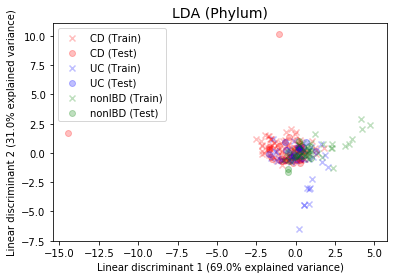

Class:
Training:   0.755
Test:       0.521


C:\ProgramData\Anaconda3\envs\cs109a\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


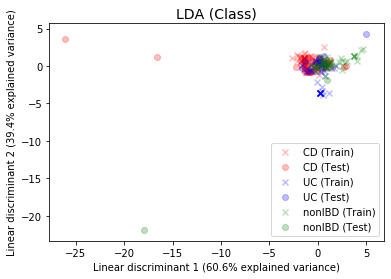

Order:
Training:   0.830
Test:       0.500


C:\ProgramData\Anaconda3\envs\cs109a\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


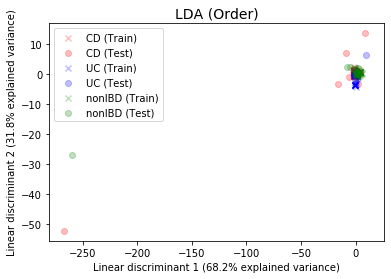

Family:
Training:   0.947
Test:       0.375


C:\ProgramData\Anaconda3\envs\cs109a\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


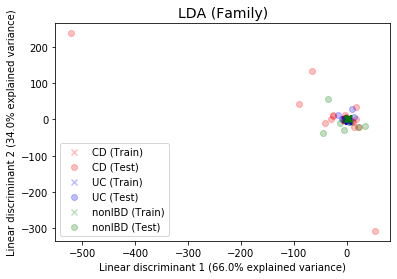

C:\ProgramData\Anaconda3\envs\cs109a\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Genus:
Training:   0.989
Test:       0.438


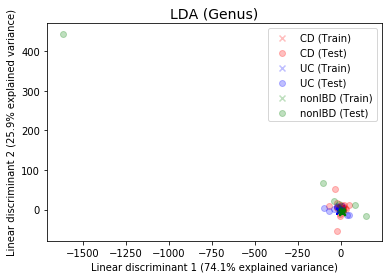

In [80]:
# Fit LDA model to bacterial abundance data
ranks = ['Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus']
lda_dict = dict.fromkeys(ranks[1:])
labels = ['CD', 'UC', 'nonIBD']
color_dict = {'nonIBD': 'g', 'UC': 'b', 'CD': 'r'}

for r in ranks[1:]: 
  # Load dataframe from file
  df_lda = pd.read_csv('IBD/' + r + '_only.csv', sep='\t', index_col='External ID')
  # Split to training and test sets
  X_train, X_test, y_train, y_test = train_test_split(df_lda.loc[:, df_lda.columns != 'diagnosis'], 
                                                      df_lda['diagnosis'], test_size=0.2, 
                                                      random_state = 109, 
                                                      stratify = df_lda['diagnosis'])
  # Standardize the data
  lda_scaler = StandardScaler().fit(X_train)
  X_train_scaled = lda_scaler.transform(X_train)
  X_test_scaled = lda_scaler.transform(X_test)
  # Fit and evaluate LDA model
  lda_dict[r] = LDA(solver='svd', shrinkage=None).fit(X_train_scaled, y_train)
  y_pred_train = lda_dict[r].predict(X_train_scaled)
  y_pred_test = lda_dict[r].predict(X_test_scaled)
  lda_acc_train = accuracy_score(y_train, y_pred_train)
  lda_acc_test = accuracy_score(y_test, y_pred_test)
  print(f'{r}:')
  print('Training:   {:.3f}'.format(lda_acc_train))
  print('Test:       {:.3f}'.format(lda_acc_test))
  # Plot
  X_train_transformed = lda_dict[r].transform(X_train_scaled)
  train_ld1 = X_train_transformed.transpose()[0]
  train_ld2 = X_train_transformed.transpose()[1]
  X_test_transformed = lda_dict[r].transform(X_test_scaled)
  test_ld1 = X_test_transformed.transpose()[0]
  test_ld2 = X_test_transformed.transpose()[1]
  ex_var = lda_dict[r].explained_variance_ratio_
  for i in range(len(labels)): 
    index = y_train == i
    plt.scatter(train_ld1[index], train_ld2[index], label=labels[i]+' (Train)', color=color_dict[labels[i]], alpha=0.25, marker='x')
    index = y_test == i
    plt.scatter(test_ld1[index], test_ld2[index], label=labels[i]+' (Test)', color=color_dict[labels[i]], alpha=0.25, marker='o')
  plt.title(f'LDA ({r})', fontsize=14)
  plt.xlabel('Linear discriminant 1 ({:.1f}% explained variance)'.format(100*ex_var[0]))
  plt.ylabel('Linear discriminant 2 ({:.1f}% explained variance)'.format(100*ex_var[1]))
#   plt.xlim([-10, 10])
#   plt.ylim([-10, 10])
  plt.legend()
  plt.show()

# Unsupervised Clustering - k-Medoids

In [3]:
# Load the data
df = pd.read_csv('IBD/Phylum_only.csv', sep='\t', index_col='External ID')

X_train, X_test, y_train, y_test = train_test_split(df.loc[:, df.columns != 'diagnosis'], 
                                                    df['diagnosis'], test_size=0.2, 
                                                    random_state = 109, 
                                                    stratify = df['diagnosis'])

In [4]:
# Scale the data
cluster_scaler = MinMaxScaler().fit(X_train)
X_train_scaled = cluster_scaler.transform(X_train)
X_test_scaled = cluster_scaler.transform(X_test)

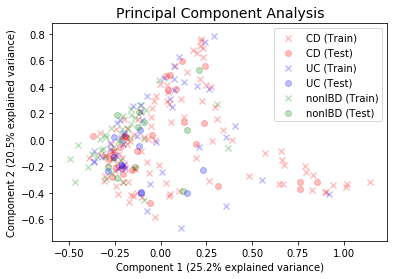

In [5]:
# Perform PCA for plotting clusters later on
cluster_pca = PCA().fit(X_train_scaled)
X_train_transformed = cluster_pca.transform(X_train_scaled)
X_test_transformed = cluster_pca.transform(X_test_scaled)

pc1_train = X_train_transformed.transpose()[0]
pc2_train = X_train_transformed.transpose()[1]
pc1_test = X_test_transformed.transpose()[0]
pc2_test = X_test_transformed.transpose()[1]
ex_var = cluster_pca.explained_variance_ratio_
labels = ['CD', 'UC', 'nonIBD']
color_dict = {'nonIBD': 'g', 'UC': 'b', 'CD': 'r'}

plt.figure()
for i in range(len(labels)): 
  index = y_train == i
  plt.scatter(pc1_train[index], pc2_train[index], label=labels[i]+' (Train)', color=color_dict[labels[i]], alpha=0.25, marker='x')
  index = y_test == i
  plt.scatter(pc1_test[index], pc2_test[index], label=labels[i]+' (Test)', color=color_dict[labels[i]], alpha=0.25, marker='o')
plt.title('Principal Component Analysis', fontsize=14)
plt.xlabel('Component 1 ({:.1f}% explained variance)'.format(100*ex_var[0]))
plt.ylabel('Component 2 ({:.1f}% explained variance)'.format(100*ex_var[1]))
# plt.xlim([-3, 5])
# plt.ylim([-3, 5])
plt.legend()
plt.show()

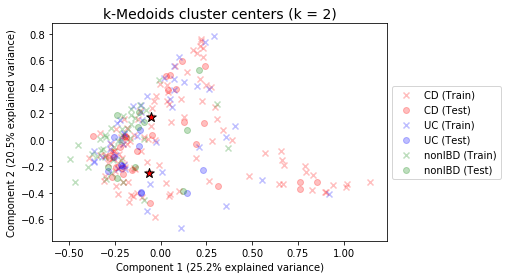

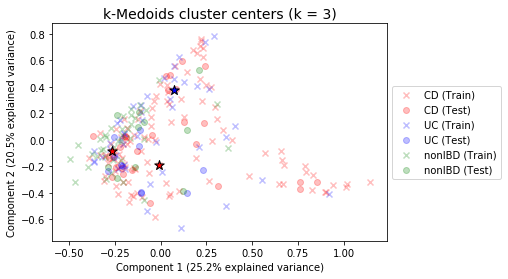

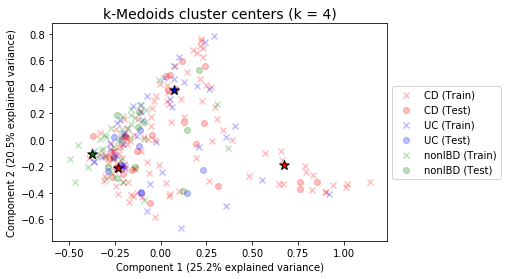

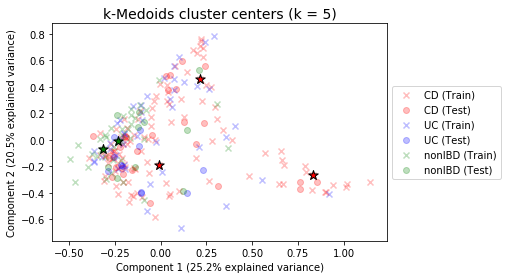

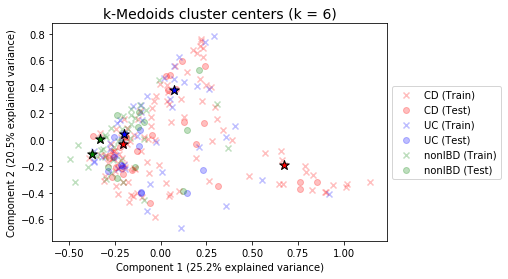

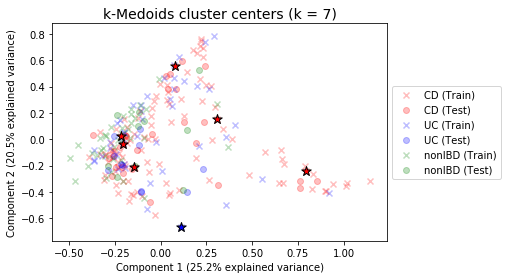

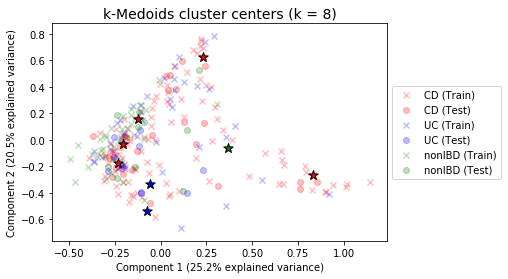

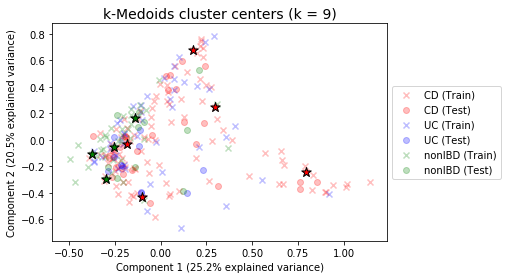

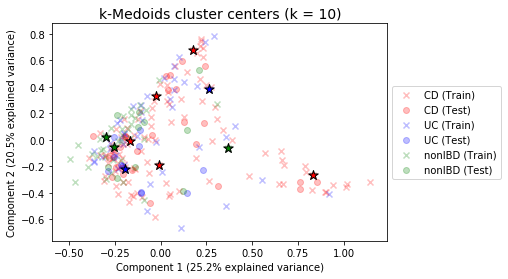

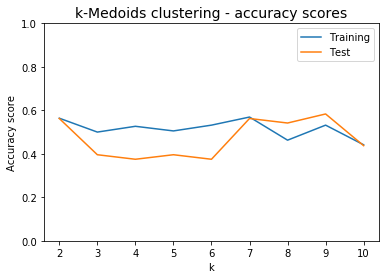

In [6]:
# Fit and evaluate k-Medoids for various k values
k_list = [2, 3, 4, 5, 6, 7, 8, 9, 10]
train_acc = []
test_acc = []
keys_list = []
for k in k_list: 
  initial_medoids = np.random.randint(len(X_train_scaled), size=k)
  medoids_model = kmedoids.kmedoids(X_train_scaled, initial_index_medoids=initial_medoids).process()
  k_df = pd.DataFrame({'cluster': range(k), 'diagnosis': y_train[medoids_model.get_medoids()]})
  k_df = k_df.set_index('cluster')
  # keys = k_df.groupby('cluster').agg(lambda x:x.value_counts().index[0])
  keys_list.append(k_df)
  cluster_pred_train = medoids_model.predict(X_train_scaled)
  y_pred_train = k_df.loc[cluster_pred_train].diagnosis
  train_acc = np.append(train_acc, accuracy_score(y_train, y_pred_train))
  cluster_pred_test = medoids_model.predict(X_test_scaled)
  y_pred_test = k_df.loc[cluster_pred_test].diagnosis
  test_acc = np.append(test_acc, accuracy_score(y_test, y_pred_test))
  plt.figure()
  for i in range(len(labels)): 
    index = y_train == i
    plt.scatter(pc1_train[index], pc2_train[index], label=labels[i]+' (Train)', color=color_dict[labels[i]], alpha=0.25, marker='x')
    index = y_test == i
    plt.scatter(pc1_test[index], pc2_test[index], label=labels[i]+' (Test)', color=color_dict[labels[i]], alpha=0.25, marker='o')
  plt.title(f'k-Medoids cluster centers (k = {k})', fontsize=14)
  plt.xlabel('Component 1 ({:.1f}% explained variance)'.format(100*ex_var[0]))
  plt.ylabel('Component 2 ({:.1f}% explained variance)'.format(100*ex_var[1]))
#   plt.xlim([-3, 3])
#   plt.ylim([-2, 2])
  plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
  for i in medoids_model.get_medoids():
    plt.scatter(pc1_train[i], pc2_train[i], s=100, marker='*', lw=1, 
                facecolor=color_dict[labels[y_train[i]]], 
                edgecolor='k')
  plt.show()

# Plot the results
plt.figure()
plt.plot(k_list, train_acc, label='Training')
plt.plot(k_list, test_acc, label='Test')
plt.ylim([0, 1])
plt.title('k-Medoids clustering - accuracy scores', fontsize=14)
plt.xlabel('k')
plt.ylabel('Accuracy score')
plt.legend()
plt.show()

In [7]:
# Report accuracy scores
kmed_df = pd.DataFrame({'k': k_list, 
                        'Training_accuracy': train_acc, 
                        'Test_accuracy': test_acc})
kmed_df = kmed_df.set_index('k')
display(kmed_df)

,Training_accuracy,Test_accuracy
k,,
2,0.563830,0.562500
3,0.500000,0.395833
4,0.526596,0.375000
5,0.505319,0.395833
6,0.531915,0.375000
7,0.569149,0.562500
8,0.462766,0.541667
9,0.531915,0.583333
10,0.441489,0.437500


# k-Nearest Neighbors

In [8]:
# Load dataframe from file
df = pd.read_csv('IBD/Phylum_metadata_onehot.csv', sep='\t', index_col='External ID')

In [9]:
# Drop columns, as decided upon during EDA
drop_word = ['drugs', 'procedure', 'condition', 'site', 'race']
drop_col = []
col_names = df.columns

for i in drop_word:
    for col in col_names:
        if i in col:
            drop_col.append(col)
                  
drop_col.remove('drugs_6month_antibiotics_0.5')
drop_col.remove('drugs_6month_antibiotics_1.0')
drop_col.append('stool')
        
df = df.drop(columns=drop_col)

In [10]:
# Split to training and test sets
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, df.columns != 'diagnosis'], 
                                                    df['diagnosis'], test_size=0.2, 
                                                    random_state = 109,
                                                    stratify = df['diagnosis'])

In [11]:
# Scale the data
stdscaler = StandardScaler().fit(X_train)
X_train_scaled = stdscaler.transform(X_train)
X_test_scaled = stdscaler.transform(X_test)
y_train = y_train.values
y_train = y_train.reshape(-1,1)
y_test = y_test.values
y_test = y_test.reshape(-1,1)

In [16]:
# define k values
k_values = [1, 2, 3, 4, 5, 6, 7, 8, 10, 25, 50, 75, 100]

# build a dictionary KNN models
KNNModels = {k: KNeighborsClassifier(n_neighbors=k) for k in k_values}

# fit each KNN model
for k_value in KNNModels: 
    KNNModels[k_value].fit(X_train_scaled, y_train)

# make predictions
knn_pred_train = {k: KNNModels[k].predict(X_train_scaled) for k in KNNModels}
knn_pred_test = {k: KNNModels[k].predict(X_test_scaled) for k in KNNModels}

In [25]:
# Evaluate the model performance on different Ks
accuracies = pd.DataFrame(columns=('k', 'train_accuracy', 'test_accuracy'))
for k in k_values:
    accuracies = accuracies.append({'k':k, 
                                    'train_accuracy':accuracy_score(y_train, knn_pred_train[k]),
                                    'test_accuracy':accuracy_score(y_test, knn_pred_test[k])}, ignore_index=True)

accuracies = accuracies.set_index('k')
display(accuracies)

,train_accuracy,test_accuracy
k,,
1.0,1.000000,0.854167
2.0,0.930851,0.708333
3.0,0.914894,0.645833
4.0,0.803191,0.625000
5.0,0.787234,0.666667
6.0,0.765957,0.645833
7.0,0.707447,0.625000
8.0,0.712766,0.604167
10.0,0.696809,0.604167


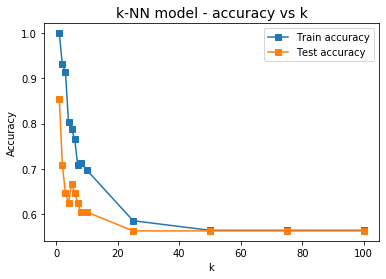

In [26]:
# Plot the accuracies over K
fig, axes = plt.subplots()
axes.plot(k_values, accuracies['train_accuracy'], 's-', label='Train accuracy')
axes.plot(k_values, accuracies['test_accuracy'], 's-', label='Test accuracy')
axes.set_xlabel('k')
axes.set_ylabel('Accuracy')
axes.set_title("k-NN model - accuracy vs k", fontsize=14)
axes.legend()
plt.show()

In [24]:
# 10-fold cross-validation with KNN 
cv_accuracies = pd.DataFrame(columns=('k', 'cv_accuracy','test_accuracy'))
for k in k_values: 
    KNN_model = KNeighborsClassifier(n_neighbors=k)
    KNN_model.fit(X_train_scaled, y_train)
    scores = cross_val_score(KNN_model, X_train_scaled, y_train, cv=10, scoring='accuracy')
    pred_test = KNN_model.predict(X_test_scaled)
    test_acc = accuracy_score(y_test, pred_test)
    cv_accuracies = cv_accuracies.append({'k':k,
                                    'cv_accuracy':scores.mean(),
                                    'test_accuracy':test_acc}, ignore_index=True)
cv_accuracies = cv_accuracies.set_index('k')
display(cv_accuracies)

,cv_accuracy,test_accuracy
k,,
1.0,0.862776,0.854167
2.0,0.697769,0.708333
3.0,0.682472,0.645833
4.0,0.668027,0.625000
5.0,0.643387,0.666667
6.0,0.641034,0.645833
7.0,0.639561,0.625000
8.0,0.663354,0.604167
10.0,0.626589,0.604167


For best model (k = 1), compare results with other datasets:

In [30]:
# Metadata only
# Load dataframe from file
df = pd.read_csv('IBD/metadata_onehot.csv', sep='\t', index_col='External ID')

# Drop columns, as decided upon during EDA
drop_word = ['drugs', 'procedure', 'condition', 'site', 'race']
drop_col = []
col_names = df.columns

for i in drop_word:
    for col in col_names:
        if i in col:
            drop_col.append(col)
                  
drop_col.remove('drugs_6month_antibiotics_0.5')
drop_col.remove('drugs_6month_antibiotics_1.0')
drop_col.append('stool')
        
df = df.drop(columns=drop_col)

# Split to training and test sets
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, df.columns != 'diagnosis'], 
                                                    df['diagnosis'], test_size=0.2, 
                                                    random_state = 109,
                                                    stratify = df['diagnosis'])

# Scale the data
stdscaler = StandardScaler().fit(X_train)
X_train_scaled = stdscaler.transform(X_train)
X_test_scaled = stdscaler.transform(X_test)
y_train = y_train.values
y_train = y_train.reshape(-1,1)
y_test = y_test.values
y_test = y_test.reshape(-1,1)

# Fit and evaluate model
knn_md_only = KNeighborsClassifier(n_neighbors=1).fit(X_train_scaled, y_train)
knn_md_only_pred_train = knn_md_only.predict(X_train_scaled)
knn_md_only_pred_test = knn_md_only.predict(X_test_scaled)
knn_md_only_acc_train = accuracy_score(y_train, knn_md_only_pred_train)
knn_md_only_acc_test = accuracy_score(y_test, knn_md_only_pred_test)

In [31]:
# Metadata and phylum-level bacterial presence
# Load dataframe from file
df = pd.read_csv('IBD/Phylum_presence_metadata_onehot.csv', sep='\t', index_col='External ID')

# Drop columns, as decided upon during EDA
drop_word = ['drugs', 'procedure', 'condition', 'site', 'race']
drop_col = []
col_names = df.columns

for i in drop_word:
    for col in col_names:
        if i in col:
            drop_col.append(col)
                  
drop_col.remove('drugs_6month_antibiotics_0.5')
drop_col.remove('drugs_6month_antibiotics_1.0')
drop_col.append('stool')
        
df = df.drop(columns=drop_col)

# Split to training and test sets
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, df.columns != 'diagnosis'], 
                                                    df['diagnosis'], test_size=0.2, 
                                                    random_state = 109,
                                                    stratify = df['diagnosis'])

# Scale the data
stdscaler = StandardScaler().fit(X_train)
X_train_scaled = stdscaler.transform(X_train)
X_test_scaled = stdscaler.transform(X_test)
y_train = y_train.values
y_train = y_train.reshape(-1,1)
y_test = y_test.values
y_test = y_test.reshape(-1,1)

# Fit and evaluate model
knn_md_presence = KNeighborsClassifier(n_neighbors=1).fit(X_train_scaled, y_train)
knn_md_presence_pred_train = knn_md_presence.predict(X_train_scaled)
knn_md_presence_pred_test = knn_md_presence.predict(X_test_scaled)
knn_md_presence_acc_train = accuracy_score(y_train, knn_md_presence_pred_train)
knn_md_presence_acc_test = accuracy_score(y_test, knn_md_presence_pred_test)

In [33]:
# Phylum-level bacterial abundance only
# Load dataframe from file
df = pd.read_csv('IBD/Phylum_only.csv', sep='\t', index_col='External ID')

# Split to training and test sets
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, df.columns != 'diagnosis'], 
                                                    df['diagnosis'], test_size=0.2, 
                                                    random_state = 109,
                                                    stratify = df['diagnosis'])

# Scale the data
stdscaler = StandardScaler().fit(X_train)
X_train_scaled = stdscaler.transform(X_train)
X_test_scaled = stdscaler.transform(X_test)
y_train = y_train.values
y_train = y_train.reshape(-1,1)
y_test = y_test.values
y_test = y_test.reshape(-1,1)

# Fit and evaluate model
knn_phylum_only = KNeighborsClassifier(n_neighbors=1).fit(X_train_scaled, y_train)
knn_phylum_only_pred_train = knn_phylum_only.predict(X_train_scaled)
knn_phylum_only_pred_test = knn_phylum_only.predict(X_test_scaled)
knn_phylum_only_acc_train = accuracy_score(y_train, knn_phylum_only_pred_train)
knn_phylum_only_acc_test = accuracy_score(y_test, knn_phylum_only_pred_test)

In [37]:
# Report model performance
accuracies_summary = {'Model': ['Phylum-level abundance and metadata', 
                                'Phylum-level presence and metadata', 
                                'Phylum-level abundance only', 
                                'Metadata only'], 
                     'Training_accuracy': [accuracies.train_accuracy.loc[1], 
                                           knn_md_presence_acc_train, 
                                           knn_phylum_only_acc_train, 
                                           knn_md_only_acc_train], 
                     'Test_accuracy': [accuracies.test_accuracy.loc[1], 
                                       knn_md_presence_acc_test, 
                                       knn_phylum_only_acc_test, 
                                       knn_md_only_acc_test]}
knn_accuracies_df = pd.DataFrame(accuracies_summary)
knn_accuracies_df = knn_accuracies_df.set_index('Model')
display(knn_accuracies_df)

,Training_accuracy,Test_accuracy
Model,,
Phylum-level abundance and metadata,1.0,0.854167
Phylum-level presence and metadata,1.0,0.812500
Phylum-level abundance only,1.0,0.500000
Metadata only,1.0,0.791667


# Tree-based Models

## Simple Decision Tree Classifier

In [94]:
# Load the data
df = pd.read_csv('IBD/metadata_numeric.csv', sep='\t', index_col='External ID')

In [95]:
# Drop columns, as decided upon during EDA
drop_word = ['drugs', 'procedure', 'condition', 'site', 'race']
drop_col = []
col_names = df.columns

for i in drop_word:
    for col in col_names:
        if i in col:
            drop_col.append(col)
                  
drop_col.remove('drugs_6month_antibiotics')
drop_col.append('stool')
        
df = df.drop(columns=drop_col)

In [96]:
# Split to training and test sets
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, df.columns != 'diagnosis'], 
                                                    df['diagnosis'], test_size=0.2, 
                                                    random_state = 109,
                                                    stratify = df['diagnosis'])

In [97]:
# Define function to run cross-validation on tree depth
def calc_meanstd(X_train, y_train, X_test, y_test, depths):
    models = []
    cvmeans = []
    cvstds = []
    train_scores = []
    cv_scores = []
    test_scores = []
    for depth in depths:
        clf = DecisionTreeClassifier(max_depth=depth)
        # Perform 5-fold cross validation and store results
        train_scores.append(clf.fit(X_train, y_train).score(X_train, y_train))
        scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=5)
        cvmeans.append(scores.mean())
        cvstds.append(scores.std())
        test_scores.append(accuracy_score(y_test, clf.predict(X_test)))
        models.append(clf)
    return models, cvmeans, cvstds, train_scores, test_scores

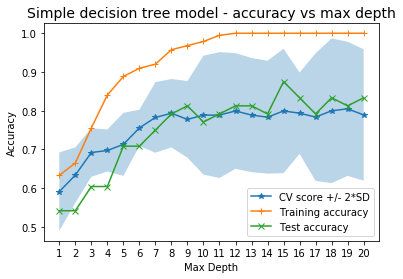

In [98]:
# Decision Tree Analysis
depths = list(range(1, 21))

tree_models, cvmeans, cvstds, train_scores, test_scores = calc_meanstd(X_train, y_train, X_test, y_test, depths)

cvmeans = np.array(cvmeans)
cvstds = np.array(cvstds)


# plot means and shade the 2 SD interval
plt.plot(depths, cvmeans, '*-', label="CV score +/- 2*SD")
plt.fill_between(depths, cvmeans - 2*cvstds, cvmeans + 2*cvstds, alpha=0.3)
plt.plot(depths, train_scores, '-+', label="Training accuracy")
plt.plot(depths, test_scores, '-x', label="Test accuracy")
ylim = plt.ylim()
plt.ylim(ylim)
plt.legend()
plt.ylabel("Accuracy")
plt.xlabel("Max Depth")
plt.xticks(depths)
plt.title('Simple decision tree model - accuracy vs max depth', fontsize=14)
plt.show()

In [99]:
# Report model performance for selected models
for d in [5, 8, 15]: 
    print(f'Simple decision tree (max depth = {d}):')
    print(f'Training accuracy:   {train_scores[d-1]:.3f}')
    print(f'Test accuracy:       {test_scores[d-1]:.3f}\n')

Simple decision tree (max depth = 5):
Training accuracy:   0.888
Test accuracy:       0.708

Simple decision tree (max depth = 8):
Training accuracy:   0.957
Test accuracy:       0.792

Simple decision tree (max depth = 15):
Training accuracy:   1.000
Test accuracy:       0.875



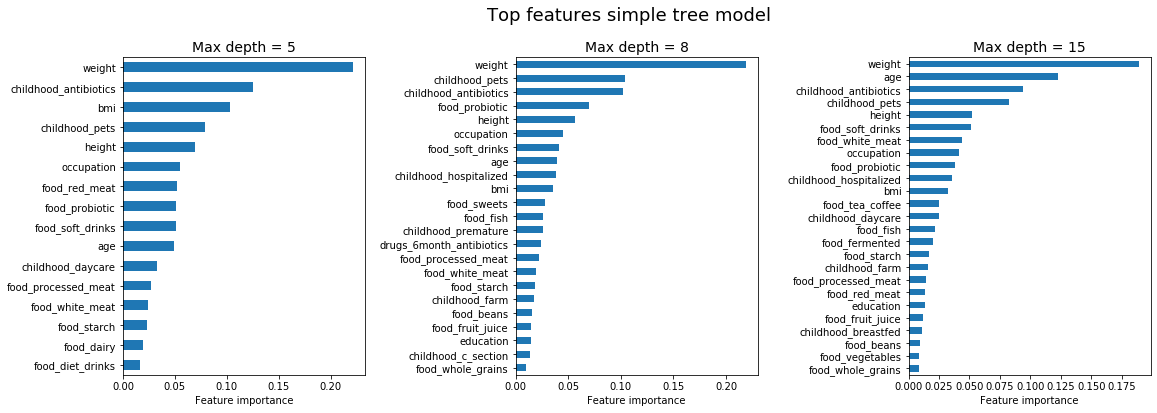

In [74]:
# Report feature importance
depth_list = [5, 8, 15]
fig, axs = plt.subplots(nrows=1, ncols=len(depth_list), figsize=(15, 5))
main_title = fig.suptitle('Top features simple tree model', fontsize=18)
main_title.set_y(1.1)
plt.gcf().tight_layout(h_pad=5, w_pad=12)

for i in range(len(depth_list)): 
    tree_keyfeatures = pd.Series(tree_models[depth_list[i]].feature_importances_,
                                 index=list(X_train)).sort_values()
    ax = axs[i]
    tree_keyfeatures[tree_keyfeatures>0].plot(kind="barh", ax=ax)
    ax.set_title(f'Max depth = {depth_list[i]}', fontsize=14)
    ax.set_xlabel('Feature importance')

plt.show()

## Random Forest

In [103]:
# Fit and evaluate Random Forest classifier
rf = RandomForestClassifier(n_estimators=55, max_features='sqrt', max_depth=15).fit(X_train,y_train)
random_forest_train_score = rf.score(X_train, y_train)
random_forest_test_score = rf.score(X_test, y_test)
print(f'Random Forest model (55 trees of depth 15):')
print(f'Training accuracy:   {random_forest_train_score:.3f}')
print(f'Test accuracy:       {random_forest_test_score:.3f}\n')

Random Forest model (55 trees of depth 15):
Training accuracy:   1.000
Test accuracy:       0.896



In [104]:
# Predictors at the top of trees in Random Forest model
top_predictors_rf = [X_train.columns[model.tree_.feature[0]]  for  model in rf.estimators_ ]
top_predictors_rf_df = pd.DataFrame(pd.Series(top_predictors_rf).value_counts(), columns=['Count'])
print('---\nRandom Forest model - predictors at top of tree\n---\n')
display(top_predictors_rf_df)

---
Random Forest model - predictors at top of tree
---



,Count
childhood_antibiotics,8
bmi,7
weight,6
food_soft_drinks,5
food_diet_drinks,4
age,4
childhood_pets,3
childhood_hospitalized,3
food_whole_grains,2
sex,1


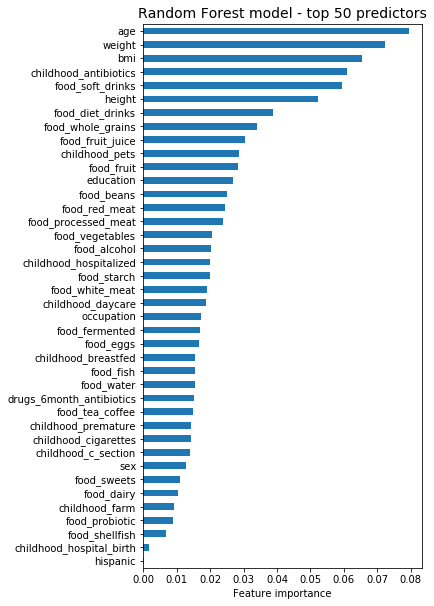

In [105]:
# Top predictors
num_top_predictors = 50
plt.figure(figsize=(5, 10))
rf_keyfeatures = pd.Series(rf.feature_importances_,index=list(X_train)).sort_values()
rf_keyfeatures[-num_top_predictors:].plot(kind="barh")
plt.title(f'Random Forest model - top {num_top_predictors} predictors', fontsize=14)
plt.xlabel('Feature importance')
plt.show()

Repeat with additional datasets and compare:

In [119]:
# Phylum-level bacterial abundance with metadata
# Load the data
df = pd.read_csv('IBD/Phylum_metadata_numeric.csv', sep='\t', index_col='External ID')

# Drop columns, as decided upon during EDA
drop_word = ['drugs', 'procedure', 'condition', 'site', 'race']
drop_col = []
col_names = df.columns

for i in drop_word:
    for col in col_names:
        if i in col:
            drop_col.append(col)
                  
drop_col.remove('drugs_6month_antibiotics')
drop_col.append('stool')
        
df = df.drop(columns=drop_col)

# Split to training and test sets
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, df.columns != 'diagnosis'], 
                                                    df['diagnosis'], test_size=0.2, 
                                                    random_state = 109,
                                                    stratify = df['diagnosis'])

# Fit and evaluate Random Forest classifier
rf_abundance_md = RandomForestClassifier(n_estimators=55, max_features='sqrt', max_depth=15).fit(X_train,y_train)
rf_abundance_md_train_score = rf_abundance_md.score(X_train, y_train)
rf_abundance_md_test_score = rf_abundance_md.score(X_test, y_test)

In [120]:
# Phylum-level bacterial presence with metadata
# Load the data
df = pd.read_csv('IBD/Phylum_presence_metadata_numeric.csv', sep='\t', index_col='External ID')

# Drop columns, as decided upon during EDA
drop_word = ['drugs', 'procedure', 'condition', 'site', 'race']
drop_col = []
col_names = df.columns

for i in drop_word:
    for col in col_names:
        if i in col:
            drop_col.append(col)
                  
drop_col.remove('drugs_6month_antibiotics')
drop_col.append('stool')
        
df = df.drop(columns=drop_col)

# Split to training and test sets
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, df.columns != 'diagnosis'], 
                                                    df['diagnosis'], test_size=0.2, 
                                                    random_state = 109,
                                                    stratify = df['diagnosis'])

# Fit and evaluate Random Forest classifier
rf_presence_md = RandomForestClassifier(n_estimators=55, max_features='sqrt', max_depth=15).fit(X_train,y_train)
rf_presence_md_train_score = rf_presence_md.score(X_train, y_train)
rf_presence_md_test_score = rf_presence_md.score(X_test, y_test)

In [121]:
# Phylum-level bacterial abundance only
# Load the data
df = pd.read_csv('IBD/Phylum_only.csv', sep='\t', index_col='External ID')

# Split to training and test sets
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, df.columns != 'diagnosis'], 
                                                    df['diagnosis'], test_size=0.2, 
                                                    random_state = 109,
                                                    stratify = df['diagnosis'])

# Fit and evaluate Random Forest classifier
rf_abundance_only = RandomForestClassifier(n_estimators=55, max_features='sqrt', max_depth=15).fit(X_train,y_train)
rf_abundance_only_train_score = rf_abundance_only.score(X_train, y_train)
rf_abundance_only_test_score = rf_abundance_only.score(X_test, y_test)

In [122]:
# Report model performance
rf_accuracies_summary = {'Model': ['Phylum-level abundance and metadata', 
                                'Phylum-level presence and metadata', 
                                'Phylum-level abundance only', 
                                'Metadata only'], 
                     'Training_accuracy': [rf_abundance_md_train_score, 
                                           rf_presence_md_train_score, 
                                           rf_abundance_only_train_score, 
                                           random_forest_train_score], 
                     'Test_accuracy': [rf_abundance_md_test_score, 
                                       rf_presence_md_test_score, 
                                       rf_abundance_only_test_score, 
                                       random_forest_test_score]}
rf_accuracies_df = pd.DataFrame(rf_accuracies_summary)
rf_accuracies_df = rf_accuracies_df.set_index('Model')
display(rf_accuracies_df)

,Training_accuracy,Test_accuracy
Model,,
Phylum-level abundance and metadata,1.0,0.854167
Phylum-level presence and metadata,1.0,0.875000
Phylum-level abundance only,1.0,0.500000
Metadata only,1.0,0.895833


## Boosting

In [106]:
# Build boosted tree models of different depths
boosted_clfs = {}
boosted_train_scores = {}
boosted_test_scores = {}
for depth in range(1, 7):
    boosted_tree = AdaBoostClassifier(
        base_estimator=DecisionTreeClassifier(max_depth=depth),
        n_estimators=400,
        learning_rate=.05).fit(X_train, y_train)
    boosted_train_scores[depth] = list(boosted_tree.staged_score(X_train, y_train))
    boosted_test_scores[depth] = list(boosted_tree.staged_score(X_test, y_test))
    boosted_clfs[depth] = boosted_tree

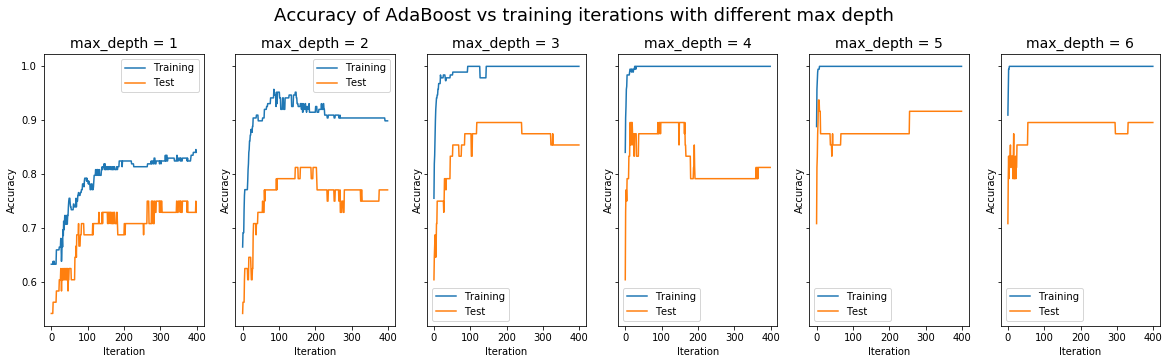

In [107]:
# Plot accuracy scores
fig, axs = plt.subplots(1, 6, figsize=(20,5), sharey=True)
for ax, depth in zip(axs, range(1, 7)):
    ax.plot(boosted_train_scores[depth], label='Training')
    ax.plot(boosted_test_scores[depth], label='Test')
    ax.set(xlabel='Iteration', ylabel='Accuracy')
    ax.set_title(f"max_depth = {depth}", fontsize=14)
    ax.legend()
main_title = fig.suptitle('Accuracy of AdaBoost vs training iterations with different max depth', fontsize=18)
main_title.set_y(1.01)
plt.show()

In [108]:
# Evaluate AdaBoost classifier
boosted_train_score = accuracy_score(y_train, boosted_clfs[5].predict(X_train))
boosted_test_score = accuracy_score(y_test, boosted_clfs[5].predict(X_test))
print(f'AdaBoost model (tree depth of 5):')
print(f'Training accuracy:   {boosted_train_score:.3f}')
print(f'Test accuracy:       {boosted_test_score:.3f}\n')

AdaBoost model (tree depth of 5):
Training accuracy:   1.000
Test accuracy:       0.917



In [109]:
# Predictors at the top of trees in AdaBoost model
top_predictors_boosted = [X_train.columns[model.tree_.feature[0]] for model in boosted_clfs[5].estimators_]
top_predictors_boosted_df = pd.DataFrame(pd.Series(top_predictors_boosted).value_counts(), columns=['Count'])
print('---\nAdaBoost model (max_depth = 5) - predictors at top of tree\n---\n')
display(top_predictors_boosted_df)

---
AdaBoost model (max_depth = 5) - predictors at top of tree
---



,Count
food_fruit_juice,106
childhood_antibiotics,58
weight,54
food_tea_coffee,53
food_dairy,24
childhood_farm,22
education,22
food_vegetables,20
food_beans,18
food_diet_drinks,15


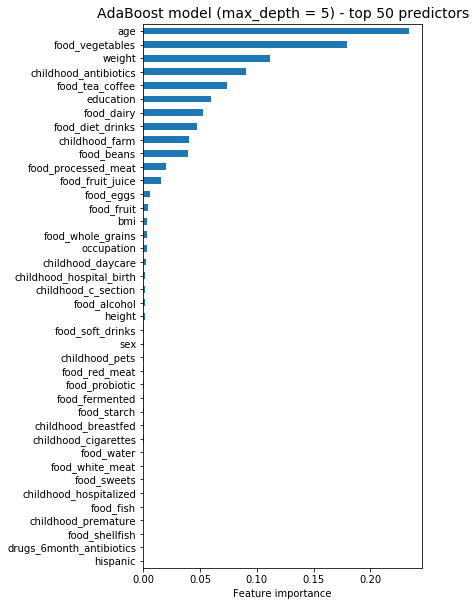

In [110]:
# Top predictors
num_top_predictors = 50
plt.figure(figsize=(5, 10))
boosted_keyfeatures = pd.Series(boosted_clfs[5].feature_importances_,index=list(X_train)).sort_values()
boosted_keyfeatures[-num_top_predictors:].plot(kind="barh")
plt.title(f'AdaBoost model (max_depth = 5) - top {num_top_predictors} predictors', fontsize=14)
plt.xlabel('Feature importance')
plt.show()

Repeat with additional datasets and compare:

In [123]:
# Phylum-level bacterial abundance with metadata
# Load the data
df = pd.read_csv('IBD/Phylum_metadata_numeric.csv', sep='\t', index_col='External ID')

# Drop columns, as decided upon during EDA
drop_word = ['drugs', 'procedure', 'condition', 'site', 'race']
drop_col = []
col_names = df.columns

for i in drop_word:
    for col in col_names:
        if i in col:
            drop_col.append(col)
                  
drop_col.remove('drugs_6month_antibiotics')
drop_col.append('stool')
        
df = df.drop(columns=drop_col)

# Split to training and test sets
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, df.columns != 'diagnosis'], 
                                                    df['diagnosis'], test_size=0.2, 
                                                    random_state = 109,
                                                    stratify = df['diagnosis'])

# Fit and evaluate Random Forest classifier
boosted_abundance_md = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=5),
                                     n_estimators=400,
                                     learning_rate=.05).fit(X_train, y_train)
boosted_abundance_md_train_score = accuracy_score(y_train, boosted_abundance_md.predict(X_train))
boosted_abundance_md_test_score = accuracy_score(y_test, boosted_abundance_md.predict(X_test))

In [124]:
# Phylum-level bacterial presence with metadata
# Load the data
df = pd.read_csv('IBD/Phylum_presence_metadata_numeric.csv', sep='\t', index_col='External ID')

# Drop columns, as decided upon during EDA
drop_word = ['drugs', 'procedure', 'condition', 'site', 'race']
drop_col = []
col_names = df.columns

for i in drop_word:
    for col in col_names:
        if i in col:
            drop_col.append(col)
                  
drop_col.remove('drugs_6month_antibiotics')
drop_col.append('stool')
        
df = df.drop(columns=drop_col)

# Split to training and test sets
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, df.columns != 'diagnosis'], 
                                                    df['diagnosis'], test_size=0.2, 
                                                    random_state = 109,
                                                    stratify = df['diagnosis'])

# Fit and evaluate Random Forest classifier
boosted_presence_md = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=5),
                                     n_estimators=400,
                                     learning_rate=.05).fit(X_train, y_train)
boosted_presence_md_train_score = accuracy_score(y_train, boosted_presence_md.predict(X_train))
boosted_presence_md_test_score = accuracy_score(y_test, boosted_presence_md.predict(X_test))

In [125]:
# Phylum-level bacterial abundance only
# Load the data
df = pd.read_csv('IBD/Phylum_only.csv', sep='\t', index_col='External ID')

# Split to training and test sets
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, df.columns != 'diagnosis'], 
                                                    df['diagnosis'], test_size=0.2, 
                                                    random_state = 109,
                                                    stratify = df['diagnosis'])

# Fit and evaluate Random Forest classifier
boosted_abundance_only = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=5),
                                     n_estimators=400,
                                     learning_rate=.05).fit(X_train, y_train)
boosted_abundance_only_train_score = accuracy_score(y_train, boosted_abundance_only.predict(X_train))
boosted_abundance_only_test_score = accuracy_score(y_test, boosted_abundance_only.predict(X_test))

In [126]:
# Report model performance
boosted_accuracies_summary = {'Model': ['Phylum-level abundance and metadata', 
                                'Phylum-level presence and metadata', 
                                'Phylum-level abundance only', 
                                'Metadata only'], 
                     'Training_accuracy': [boosted_abundance_md_train_score, 
                                           boosted_presence_md_train_score, 
                                           boosted_abundance_only_train_score, 
                                           boosted_train_score], 
                     'Test_accuracy': [boosted_abundance_md_test_score, 
                                       boosted_presence_md_test_score, 
                                       boosted_abundance_only_test_score, 
                                       boosted_test_score]}
boosted_accuracies_df = pd.DataFrame(boosted_accuracies_summary)
boosted_accuracies_df = boosted_accuracies_df.set_index('Model')
display(boosted_accuracies_df)

,Training_accuracy,Test_accuracy
Model,,
Phylum-level abundance and metadata,1.0,0.770833
Phylum-level presence and metadata,1.0,0.833333
Phylum-level abundance only,1.0,0.479167
Metadata only,1.0,0.916667


## Comparison and variable permutation of tree-based models

In [111]:
# Confusion matrices
boosted_pred_test = boosted_clfs[5].predict(X_test)
tree5_pred_test = tree_models[4].predict(X_test)
rf_pred_test = rf.predict(X_test)

print('---\nSimple tree (depth 5):\n---')
tree5_confusion_matrix = pd.DataFrame(confusion_matrix(y_test,tree5_pred_test), 
                                      index=['True_CD', 'True_UC', 'True_nonIBD'], 
                                      columns=['Predicted_CD', 'Predicted_UC', 'Predicted_nonIBD'])
display(tree5_confusion_matrix)
print('\n')

print('---\nRandom Forest 55 with tree depth 15:\n---')
rf_confusion_matrix = pd.DataFrame(confusion_matrix(y_test,rf_pred_test), 
                                   index=['True_CD', 'True_UC', 'True_nonIBD'], 
                                   columns=['Predicted_CD', 'Predicted_UC', 'Predicted_nonIBD'])
display(rf_confusion_matrix)
print('\n')

print('---\nAdaBoost model (depth 5):\n---')
boosted_confusion_matrix = pd.DataFrame(confusion_matrix(y_test,boosted_pred_test), 
                                        index=['True_CD', 'True_UC', 'True_nonIBD'], 
                                        columns=['Predicted_CD', 'Predicted_UC', 'Predicted_nonIBD'])
display(boosted_confusion_matrix)
print('\n')

print('---\nPerfect accuracy (for reference):\n---')
prefect_confusion_matrix = pd.DataFrame(confusion_matrix(y_test,y_test), 
                                        index=['True_CD', 'True_UC', 'True_nonIBD'], 
                                        columns=['Predicted_CD', 'Predicted_UC', 'Predicted_nonIBD'])
display(prefect_confusion_matrix)

---
Simple tree (depth 5):
---


,Predicted_CD,Predicted_UC,Predicted_nonIBD
True_CD,24,0,3
True_UC,4,6,1
True_nonIBD,5,1,4




---
Random Forest 55 with tree depth 15:
---


,Predicted_CD,Predicted_UC,Predicted_nonIBD
True_CD,27,0,0
True_UC,1,8,2
True_nonIBD,2,0,8




---
AdaBoost model (depth 5):
---


,Predicted_CD,Predicted_UC,Predicted_nonIBD
True_CD,25,0,2
True_UC,2,9,0
True_nonIBD,0,0,10




---
Perfect accuracy (for reference):
---


,Predicted_CD,Predicted_UC,Predicted_nonIBD
True_CD,27,0,0
True_UC,0,11,0
True_nonIBD,0,0,10


In [112]:
# Compare performance of models
df_tree_scores = pd.DataFrame({'Model': ['Single tree (depth 5)', 
                                        'Single tree (depth 8)', 
                                        'Single tree (depth 15)', 
                                        'Random Forest', 
                                        'AdaBoost'], 
                              'Training_accuracy': [train_scores[4], 
                                                   train_scores[7], 
                                                   train_scores[14], 
                                                   random_forest_train_score, 
                                                   boosted_train_score], 
                              'Test_accuracy': [test_scores[4], 
                                                test_scores[7], 
                                                test_scores[14], 
                                                random_forest_test_score, 
                                                boosted_test_score]})
df_tree_scores = df_tree_scores.set_index('Model')
display(df_tree_scores)

,Training_accuracy,Test_accuracy
Model,,
Single tree (depth 5),0.888298,0.708333
Single tree (depth 8),0.957447,0.791667
Single tree (depth 15),1.000000,0.875000
Random Forest,1.000000,0.895833
AdaBoost,1.000000,0.916667


In [115]:
# Permutation importance of top variables with Random Forest model
importances_rf = rf.feature_importances_
indices_rf = np.argsort(importances_rf)[::-1]
features = df.columns
features = features.drop('diagnosis')
features_test = features[indices_rf[:10]]
test_loss = np.zeros(len(features_test))
test_accuracy = np.zeros(len(features_test))
df_perm = pd.DataFrame(X_test, columns=features)


for i in range(len(features_test)):
    df_temp = df_perm.copy()
    df_temp[features_test[i]] = np.random.permutation(df_temp[features_test[i]].values)
    X_test_perm = df_temp.values
    test_accuracy[i] = rf.score(X_test_perm, y_test)   

# create table
permut_df = pd.DataFrame(list(zip(features_test, test_accuracy)), columns=['Feature', 'Test accuracy'])
print('---\nRandom Forest - permutation importance of top features:\n---')
display(permut_df)

---
Random Forest - permutation importance of top features:
---


,Feature,Test accuracy
0,age,0.875000
1,weight,0.895833
2,bmi,0.875000
3,childhood_antibiotics,0.895833
4,food_soft_drinks,0.875000
5,height,0.895833
6,food_diet_drinks,0.875000
7,food_whole_grains,0.895833
8,food_fruit_juice,0.895833
9,childhood_pets,0.895833


In [117]:
# Permutation of variables with AdaBoost model
importances_boosted_tree5 = boosted_clfs[5].feature_importances_
indices_boosted_tree5 = np.argsort(importances_boosted_tree5)[::-1]
features = df.columns
features = features.drop('diagnosis')
features_test = features[indices_boosted_tree5[:10]]
test_loss = np.zeros(len(features_test))
test_accuracy = np.zeros(len(features_test))
df_perm = pd.DataFrame(X_test, columns=features)


for i in range(len(features_test)):
    df_temp = df_perm.copy()
    df_temp[features_test[i]] = np.random.permutation(df_temp[features_test[i]].values)
    X_test_perm = df_temp.values
    test_accuracy[i] = boosted_clfs[5].score(X_test_perm, y_test)   

# create table
permut_df = pd.DataFrame(list(zip(features_test, test_accuracy)), columns=['feature', 'test accuracy'])
print('---\nAdaBoost model - permutation importance of top features\n---')
display(permut_df)

---
AdaBoost model - permutation importance of top features
---


,feature,test accuracy
0,age,0.791667
1,food_vegetables,0.916667
2,weight,0.750000
3,childhood_antibiotics,0.812500
4,food_tea_coffee,0.812500
5,education,0.895833
6,food_dairy,0.937500
7,food_diet_drinks,0.895833
8,childhood_farm,0.854167
9,food_beans,0.895833


# Neural Network

In [38]:
# Load dataframe from file
df = pd.read_csv('IBD/Phylum_metadata_onehot.csv', sep='\t', index_col='External ID')

In [4]:
# Drop columns, as decided upon during EDA
drop_word = ['drugs', 'procedure', 'condition', 'site', 'race']
drop_col = []
col_names = df.columns

for i in drop_word:
    for col in col_names:
        if i in col:
            drop_col.append(col)
                  
drop_col.remove('drugs_6month_antibiotics_0.5')
drop_col.remove('drugs_6month_antibiotics_1.0')
drop_col.append('stool')
        
df = df.drop(columns=drop_col)

In [5]:
# Split to training and test sets
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, df.columns != 'diagnosis'], 
                                                    df['diagnosis'], test_size=0.2, 
                                                    random_state = 109,
                                                    stratify = df['diagnosis'])

In [6]:
# Scale data
minmaxscaler = MinMaxScaler().fit(X_train)
X_train_norm = minmaxscaler.transform(X_train)
X_test_norm = minmaxscaler.transform(X_test)
y_train = y_train.values
y_train = y_train.reshape(-1,1)
y_test = y_test.values
y_test = y_test.reshape(-1,1)

In [47]:
# build the fully-connected neural network
model = tf.keras.models.Sequential([
    tf.keras.layers.Dropout(0.2), 
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dropout(0.2), 
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dropout(0.2), 
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dropout(0.2), 
    tf.keras.layers.Dense(3, activation='softmax')])

optimizer = tf.keras.optimizers.Adam(lr=0.01)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

In [48]:
# Fit the model
history = model.fit(X_train_norm, y_train, validation_split=0.2, batch_size=32, epochs=100, verbose=2)

Train on 150 samples, validate on 38 samples
Epoch 1/100
150/150 - 1s - loss: 1.0371 - accuracy: 0.5133 - val_loss: 0.9479 - val_accuracy: 0.5263
Epoch 2/100
150/150 - 0s - loss: 0.9181 - accuracy: 0.6000 - val_loss: 0.8961 - val_accuracy: 0.6842
Epoch 3/100
150/150 - 0s - loss: 0.7935 - accuracy: 0.6333 - val_loss: 0.8182 - val_accuracy: 0.5789
Epoch 4/100
150/150 - 0s - loss: 0.6332 - accuracy: 0.7400 - val_loss: 0.7231 - val_accuracy: 0.7632
Epoch 5/100
150/150 - 0s - loss: 0.6245 - accuracy: 0.7933 - val_loss: 0.7217 - val_accuracy: 0.6842
Epoch 6/100
150/150 - 0s - loss: 0.4776 - accuracy: 0.7733 - val_loss: 0.8203 - val_accuracy: 0.8158
Epoch 7/100
150/150 - 0s - loss: 0.4738 - accuracy: 0.8333 - val_loss: 0.6920 - val_accuracy: 0.7895
Epoch 8/100
150/150 - 0s - loss: 0.4053 - accuracy: 0.8467 - val_loss: 0.7544 - val_accuracy: 0.7105
Epoch 9/100
150/150 - 0s - loss: 0.2487 - accuracy: 0.9133 - val_loss: 0.6596 - val_accuracy: 0.8421
Epoch 10/100
150/150 - 0s - loss: 0.2243 - acc

Epoch 81/100
150/150 - 0s - loss: 0.0506 - accuracy: 0.9867 - val_loss: 0.7897 - val_accuracy: 0.8684
Epoch 82/100
150/150 - 0s - loss: 0.0324 - accuracy: 0.9867 - val_loss: 0.8287 - val_accuracy: 0.8684
Epoch 83/100
150/150 - 0s - loss: 0.0246 - accuracy: 0.9933 - val_loss: 0.7255 - val_accuracy: 0.8684
Epoch 84/100
150/150 - 0s - loss: 0.0407 - accuracy: 0.9933 - val_loss: 0.6595 - val_accuracy: 0.8947
Epoch 85/100
150/150 - 0s - loss: 0.0242 - accuracy: 0.9933 - val_loss: 0.8257 - val_accuracy: 0.9211
Epoch 86/100
150/150 - 0s - loss: 0.1389 - accuracy: 0.9733 - val_loss: 0.8324 - val_accuracy: 0.8947
Epoch 87/100
150/150 - 0s - loss: 0.0081 - accuracy: 1.0000 - val_loss: 0.9144 - val_accuracy: 0.9211
Epoch 88/100
150/150 - 0s - loss: 0.0985 - accuracy: 0.9667 - val_loss: 0.5610 - val_accuracy: 0.9211
Epoch 89/100
150/150 - 0s - loss: 0.1270 - accuracy: 0.9533 - val_loss: 0.4018 - val_accuracy: 0.9474
Epoch 90/100
150/150 - 0s - loss: 0.0558 - accuracy: 0.9800 - val_loss: 0.7119 - v

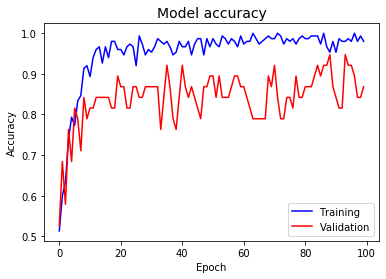

In [49]:
# Plot accuracy scores
plt.plot(history.history['accuracy'], 'b',label='Training')
plt.plot(history.history['val_accuracy'], 'r', label='Validation')
plt.legend(loc='lower right')
plt.title('Model accuracy', fontsize=14)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

In [50]:
# Evaluate model accuracy
test_loss, test_accuracy = model.evaluate(X_test_norm, y_test)

48/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [51]:
# Report confusion matrix
labels = ['CD', 'UC', 'nonIBD']
y_predict = model.predict(X_test_norm)
y_predict_class = np.argmax(y_predict, axis=1)
nn_confusion_matrix = pd.DataFrame(confusion_matrix(y_test.flatten(), y_predict_class.flatten()), 
                                  index=['True_CD', 'True_UC', 'True_nonIBD'], 
                                  columns=['Predicted_CD', 'Predicted_UC', 'Predicted_nonIBD'])
print('---\nNN model - confusion matrix:\n---')
display(nn_confusion_matrix)

---
NN model - confusion matrix:
---


,Predicted_CD,Predicted_UC,Predicted_nonIBD
True_CD,26,0,1
True_UC,3,8,0
True_nonIBD,2,0,8


In [52]:
# model a decision tree on NN predictions
# use NN model to make predictions
y_predict_train = model.predict(X_train_norm)
y_predict_train_class = np.argmax(y_predict_train, axis=1)

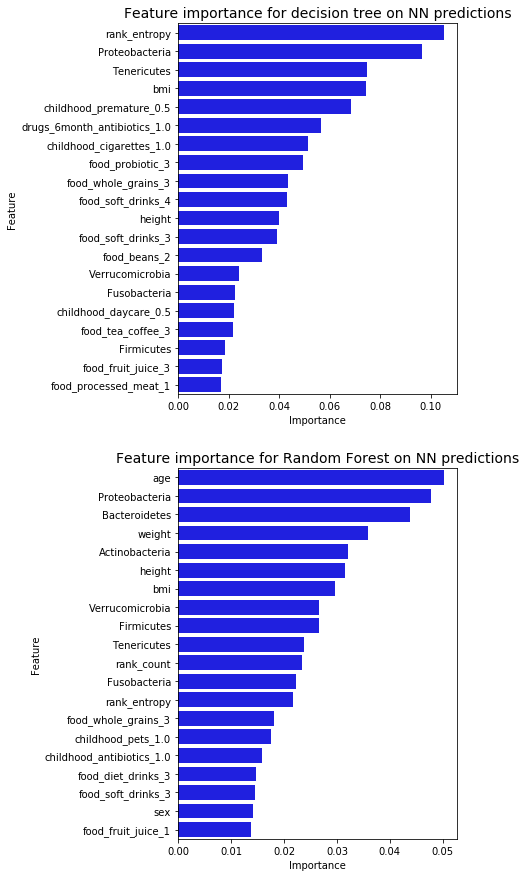

In [53]:
#simple tree with depth 10
tree10 = DecisionTreeClassifier(max_depth=10).fit(X_train_norm, y_predict_train_class)

# random forest with depth 10
rf10 = RandomForestClassifier(n_estimators=50, max_features='sqrt', max_depth=10).fit(X_train_norm, y_predict_train_class)

# feature importance
importances_tree = tree10.feature_importances_
indices_tree = np.argsort(importances_tree)[::-1]
importances_rf = rf10.feature_importances_
indices_rf = np.argsort(importances_rf)[::-1]

features = df.columns
features = features.drop('diagnosis')

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(5, 15))
tree10_df = pd.DataFrame(list(zip(features[indices_tree[:20]], importances_tree[indices_tree[:20]])), columns=['feature','importance'])
sns.barplot(y='feature', x='importance', data=tree10_df, color='b', ax=ax[0])
ax[0].set_ylabel('Feature')
ax[0].set_xlabel('Importance')
ax[0].set_title('Feature importance for decision tree on NN predictions', fontsize=14)

rf_df = pd.DataFrame(list(zip(features[indices_rf[:20]], importances_rf[indices_rf[:20]])), columns=['feature','importance'])
sns.barplot(y='feature', x='importance', data=rf_df, color='b', ax=ax[1])
ax[1].set_ylabel('Feature')
ax[1].set_xlabel('Importance')
ax[1].set_title('Feature importance for Random Forest on NN predictions', fontsize=14)

plt.show()